# ===========================
# Benchmarking the PPI 
# ===========================

In [2]:
# import
from multidimvis_main import *

In [3]:
def embed_umap_2D(Matrix, n_neighbors, spread, min_dist, metric='cosine', learn_rate = 1, n_ep = None):
    '''
    Dimensionality reduction from Matrix using UMAP.
    Return dict (keys: node IDs, values: x,y).
    ''' 
    n_components = 2 

    U = umap.UMAP(
        n_neighbors = n_neighbors,
        spread = spread,
        min_dist = min_dist,
        n_components = n_components,
        metric = metric, 
        random_state=42,
        learning_rate = learn_rate, 
        n_epochs = n_ep)
    
    embed = U.fit_transform(Matrix)
    
    return embed


# add functions to multidimvis_main 

def embed_umap_2D(Matrix, n_neigh, spre, m_dist, metric='cosine', learn_rate = 1, n_ep = None):
    '''
    Dimensionality reduction from Matrix using UMAP.
    Return dict (keys: node IDs, values: x,y).
    ''' 
    n_comp = 2 

    U = umap.UMAP(
        n_neighbors = n_neigh,
        spread = spre,
        min_dist = m_dist,
        n_components = n_comp,
        metric = metric, 
        random_state=42,
        learning_rate = learn_rate, 
        n_epochs = n_ep)
    
    embed = U.fit_transform(Matrix)
    
    return embed


def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 3)), int(round(m, 0)), int(round(h, 0))
    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
   
    return m,s


def embed_umap_3D(Matrix, n_neighbors, spread, min_dist, metric='cosine', learn_rate = 1, n_ep = None):
    '''
    Dimensionality reduction from Matrix (UMAP).
    Return dict (keys: node IDs, values: x,y,z).
    '''

    n_components = 3 # for 3D

    U_3d = umap.UMAP(
        n_neighbors = n_neighbors,
        spread = spread,
        min_dist = min_dist,
        n_components = n_components,
        metric = metric,
        random_state=42,
        learning_rate = learn_rate, 
        n_epochs = n_ep)
    embed = U_3d.fit_transform(Matrix)
    
    return embed

In [3]:
################################################
#
# Y E A S T 
#
################################################

organism = 'Yeast'

data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)
G = G_cere

posG_entrez = []
for k in G.nodes():
    posG_entrez.append(k[22:])
    
df_gID_sym = pd.read_csv('input/Yeast_geneID_sym.csv', index_col=0)
gene_sym = list(df_gID_sym['Sym'])
gene_id = list(df_gID_sym.index)
g_ID_sym = dict(list(zip(gene_id, gene_sym)))
#len(g_ID_sym)
    
l_features = []
for i in g_ID_sym.values():
    l_features.append(i)
    
# ESSENTIALITY 

cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
 
cere_sym = list(cere_gene['symbols'])
cere_ess = list(cere_gene['essentiality status'])
cere_sym_essentiality = dict(zip(cere_sym, cere_ess))

d_cere_ess = {}
d_cere_noess = {}
d_cere_unknown = {}

for node,es in cere_sym_essentiality.items():
    if es == 'E':
        d_cere_ess[node]=es
    elif es == 'NE':
        d_cere_noess[node]=es
        
d_cere_alless = {}
for nid, sym in g_ID_sym.items():
    for sy,ess in cere_sym_essentiality.items():
        if sym == sy:
            d_cere_alless[nid] = ess
            
d_cere_unknown = {} 
for g in G.nodes():
    if g not in d_cere_alless.keys():
        d_cere_unknown[g]='status unkonwn'
    
d_geneID_ess = {**d_cere_unknown, **d_cere_alless}

d_gID_ess = {}
d_gID_noess = {}
d_gID_notdef = {}

for k,i in d_geneID_ess.items():
    if i == 'E':
        d_gID_ess[k] = i
    elif i == 'NE':
        d_gID_noess[k] = i
    else: 
        d_gID_notdef[k] = 'not defined'

d_gID_all_unsorted = {**d_gID_ess, **d_gID_noess, **d_gID_notdef}
d_gID_all = {key:d_gID_all_unsorted[key] for key in G.nodes()}

essential_genes = []
non_ess_genes = []
notdefined_genes = [] 
for k,v in d_gID_all.items():
    if v == 'E':
        essential_genes.append(k)
    elif v == 'NE':
        non_ess_genes.append(k)
    else:
        notdefined_genes.append(k)
        
# Centrality features 
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

In [4]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}
    
# Gene Symbols 
df_gene_sym = pd.read_csv('_output_csv/DF_gene_symbol_Human.csv', index_col=0)
sym = list(df_gene_sym['0'])
l_features = []
for i in sym:
    l_features.append(i[2:-2])
d_gene_sym = dict(zip(G.nodes(),l_features))


# ESSENTIALITY 
# get dataframe with ENSG-ID and essentiality state 
df_human_ess = pd.read_table('input/human_essentiality.txt', delim_whitespace=True)

# create dict with ENSG-ID:essentiality state 
ensg_id = list(set(df_human_ess['sciName']))
gene_ess = list(df_human_ess['locus'])
d_ensg_ess = dict(zip(ensg_id, gene_ess))
 
# match ENSG-ID with entrezID
# "engs_to_entrezid": entrezIDs were matched with "ensg_id.txt" via "DAVID Database" (https://david.ncifcrf.gov/conversion.jsp)
df_human_ensg_entrez = pd.read_table('input/ensg_to_entrezid.txt')# delim_whitespace=False)
df_human_ensg_entrez.dropna()

df = df_human_ensg_entrez
df['To'] = df['To'].fillna(0)
df['To'] = df['To'].astype(int)
df_human_ensg_entrez = df

# create dict with ENGS-ID: entrezID
ensgid = list(df_human_ensg_entrez['From']) #engs ID
entrezid = list(df_human_ensg_entrez['To']) #entrez ID 

# dict with engsid : entrezid
d_ensg_entrez = dict(zip(ensgid, entrezid))

# create dict with entrezID:essentiality state 
d_id_ess_unsorted = {}
for ens,ent in d_ensg_entrez.items():
    for en, ess in d_ensg_ess.items():
        if ens == en:
            d_id_ess_unsorted[str(ent)] = ess
            
            
# check if G.nodes match entrezID in dict and sort according to G.nodes 
d_gid_ess = {}
for k,v in d_id_ess_unsorted.items():
    if k in G.nodes():
        d_gid_ess[k]=v
        
# create dict with rest of G.nodes not in dict (entrezID:essentiality)
d_gid_rest = {}
for g in G.nodes():
    if g not in d_gid_ess.keys():
        d_gid_rest[g]='not defined'
        
#print(len(d_gid_rest)+len(d_gid_ess)) # this should match G.nodes count 

# merge both dicts
d_gid_ess_all_unsorted = {**d_gid_ess, **d_gid_rest}

# sort -> G.nodes()
d_gID_all = {key:d_gid_ess_all_unsorted[key] for key in G.nodes()}

essential_genes = []
non_ess_genes = []
notdefined_genes = [] 
for k,v in d_gID_all.items():
    if v == 'E':
        essential_genes.append(k)
    elif v == 'NE':
        non_ess_genes.append(k)
    else:
        notdefined_genes.append(k)
        
        
# Centrality features 
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

## NETWORK

In [5]:
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.11f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Network: Human
Number of nodes: 16376
Number of edges: 309355
Network density: 0.23071268727%


____________
## PRE-SETTINGS
____________

+ PREDEFINED FEATURE MATRIX

In [419]:
feature_df = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))
DM_cent.index = list(G.nodes())
DM_cent.columns = list(G.nodes())

In [436]:
# General Parameters:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
edge_colorlight = edge_col
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = 'black'

# Node sizes 

#scalef= 0.2
#size = list(draw_node_degree(G, scalef).values())

#scalef= 0.05
#size3d = list(draw_node_degree_3D(G, scalef).values())

color_method = 'deg'
d_colours = color_nodes_from_dict(G, d_deghubs, palette = 'YlOrRd')
colours = list(d_colours.values())

labelsize = 18
legendfontsize = 12

___________
## NETWORK DISTANCE 
___________

In [7]:
DM_spl_2D = pd.read_csv("_output_csv/SPL_Dataframe_"+organism+".csv",index_col=0)
DM_spl_2D.index = list(G.nodes())

In [8]:
dist_network2D = {}
for p1, p2 in it.combinations(DM_spl_2D.index,2):
    dist_network2D[p1,p2] = DM_spl_2D[p1][p2]

In [422]:
# for yeast only 

DM_spl_2D_mod = DM_spl_2D.replace(np.nan, max(DM_spl_2D.max(axis=0)))

dist_network2D_mod = {}
for p1, p2 in it.combinations(DM_spl_2D_mod.index,2):
    dist_network2D_mod[p1,p2] = DM_spl_2D_mod[p1][p2]

______________
# 2D BENCHMARK - visual + statistical 
______________

### SPRING

In [433]:
%%time

niter = 10 
posG_spring2D = nx.spring_layout(G, iterations = niter, dim = 2)

df_posG = pd.DataFrame(posG_spring2D).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

plt.figure(figsize=(25,25))
plt.title('Spring', size= 16)

nx.draw_networkx_nodes(G, posG_spring2D_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color = colours, 
                       node_size= 50, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_spring2D_norm, width = edge_width, 
                       edge_color = edge_col, alpha = 0.1)#opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dspring_'+organism+'.png')

plt.show()

CPU times: user 2min 10s, sys: 1min 33s, total: 3min 44s
Wall time: 4min 38s


## 2D PORTRAITS 

+ ADJACENCIES

In [21]:
%%time

n_neighbors = 50 # 20 # balance between local and global structure in the data
spread = 1.0 # 10
min_dist = 0.1 # 0.9 #defines how dense points are stacked together 
metric ='cosine'

feature = 'ADJ'

A = nx.adjacency_matrix(G)
adj = A.toarray()
DM_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))

umap_adj = embed_umap_2D(DM_adj, n_neighbors, spread, min_dist, metric)

posG_umap_adj = get_posG_2D(list(G.nodes()), umap_adj)
posG_complete_umap_adj = {key:posG_umap_adj[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_adj).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_adj_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_adj_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 50, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_adj_norm, width = edge_width, 
                       edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning:

A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 34513 edges.
It has only fully disconnected 27 vertices.
Use umap.utils.disconnected_vertices() to identify them.



CPU times: user 1min 56s, sys: 1.38 s, total: 1min 57s
Wall time: 51.2 s


+ RANDOM WALK - visiting probability 

In [434]:
##############################
# Y E A S T
##############################

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 10 #50
spread = 10
min_dist = 0.5 #0.01

metric = 'cosine'
lnr = 1
nep = None


##############################
# H U M A N  
##############################

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 50
spread = 1
min_dist = 0.5
metric = 'cosine'
lnr = 1
nep = None

In [415]:
%%time 

feature = 'RWRvis'

r = .9 # restart probability; originally 0.8
alpha = 1.0
# alpha = 0.5 # --> better results for torus 

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
DM_rwr = FM_m 

umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_rwr).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_rwr_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 50, #100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_rwr_norm, width = edge_width, 
                       edge_color = edge_col, alpha = 0.1)#opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
plt.show()

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



Network: Yeast
Number of nodes: 5785
Number of edges: 31237


CPU times: user 5min 35s, sys: 18.5 s, total: 5min 53s
Wall time: 1min 38s


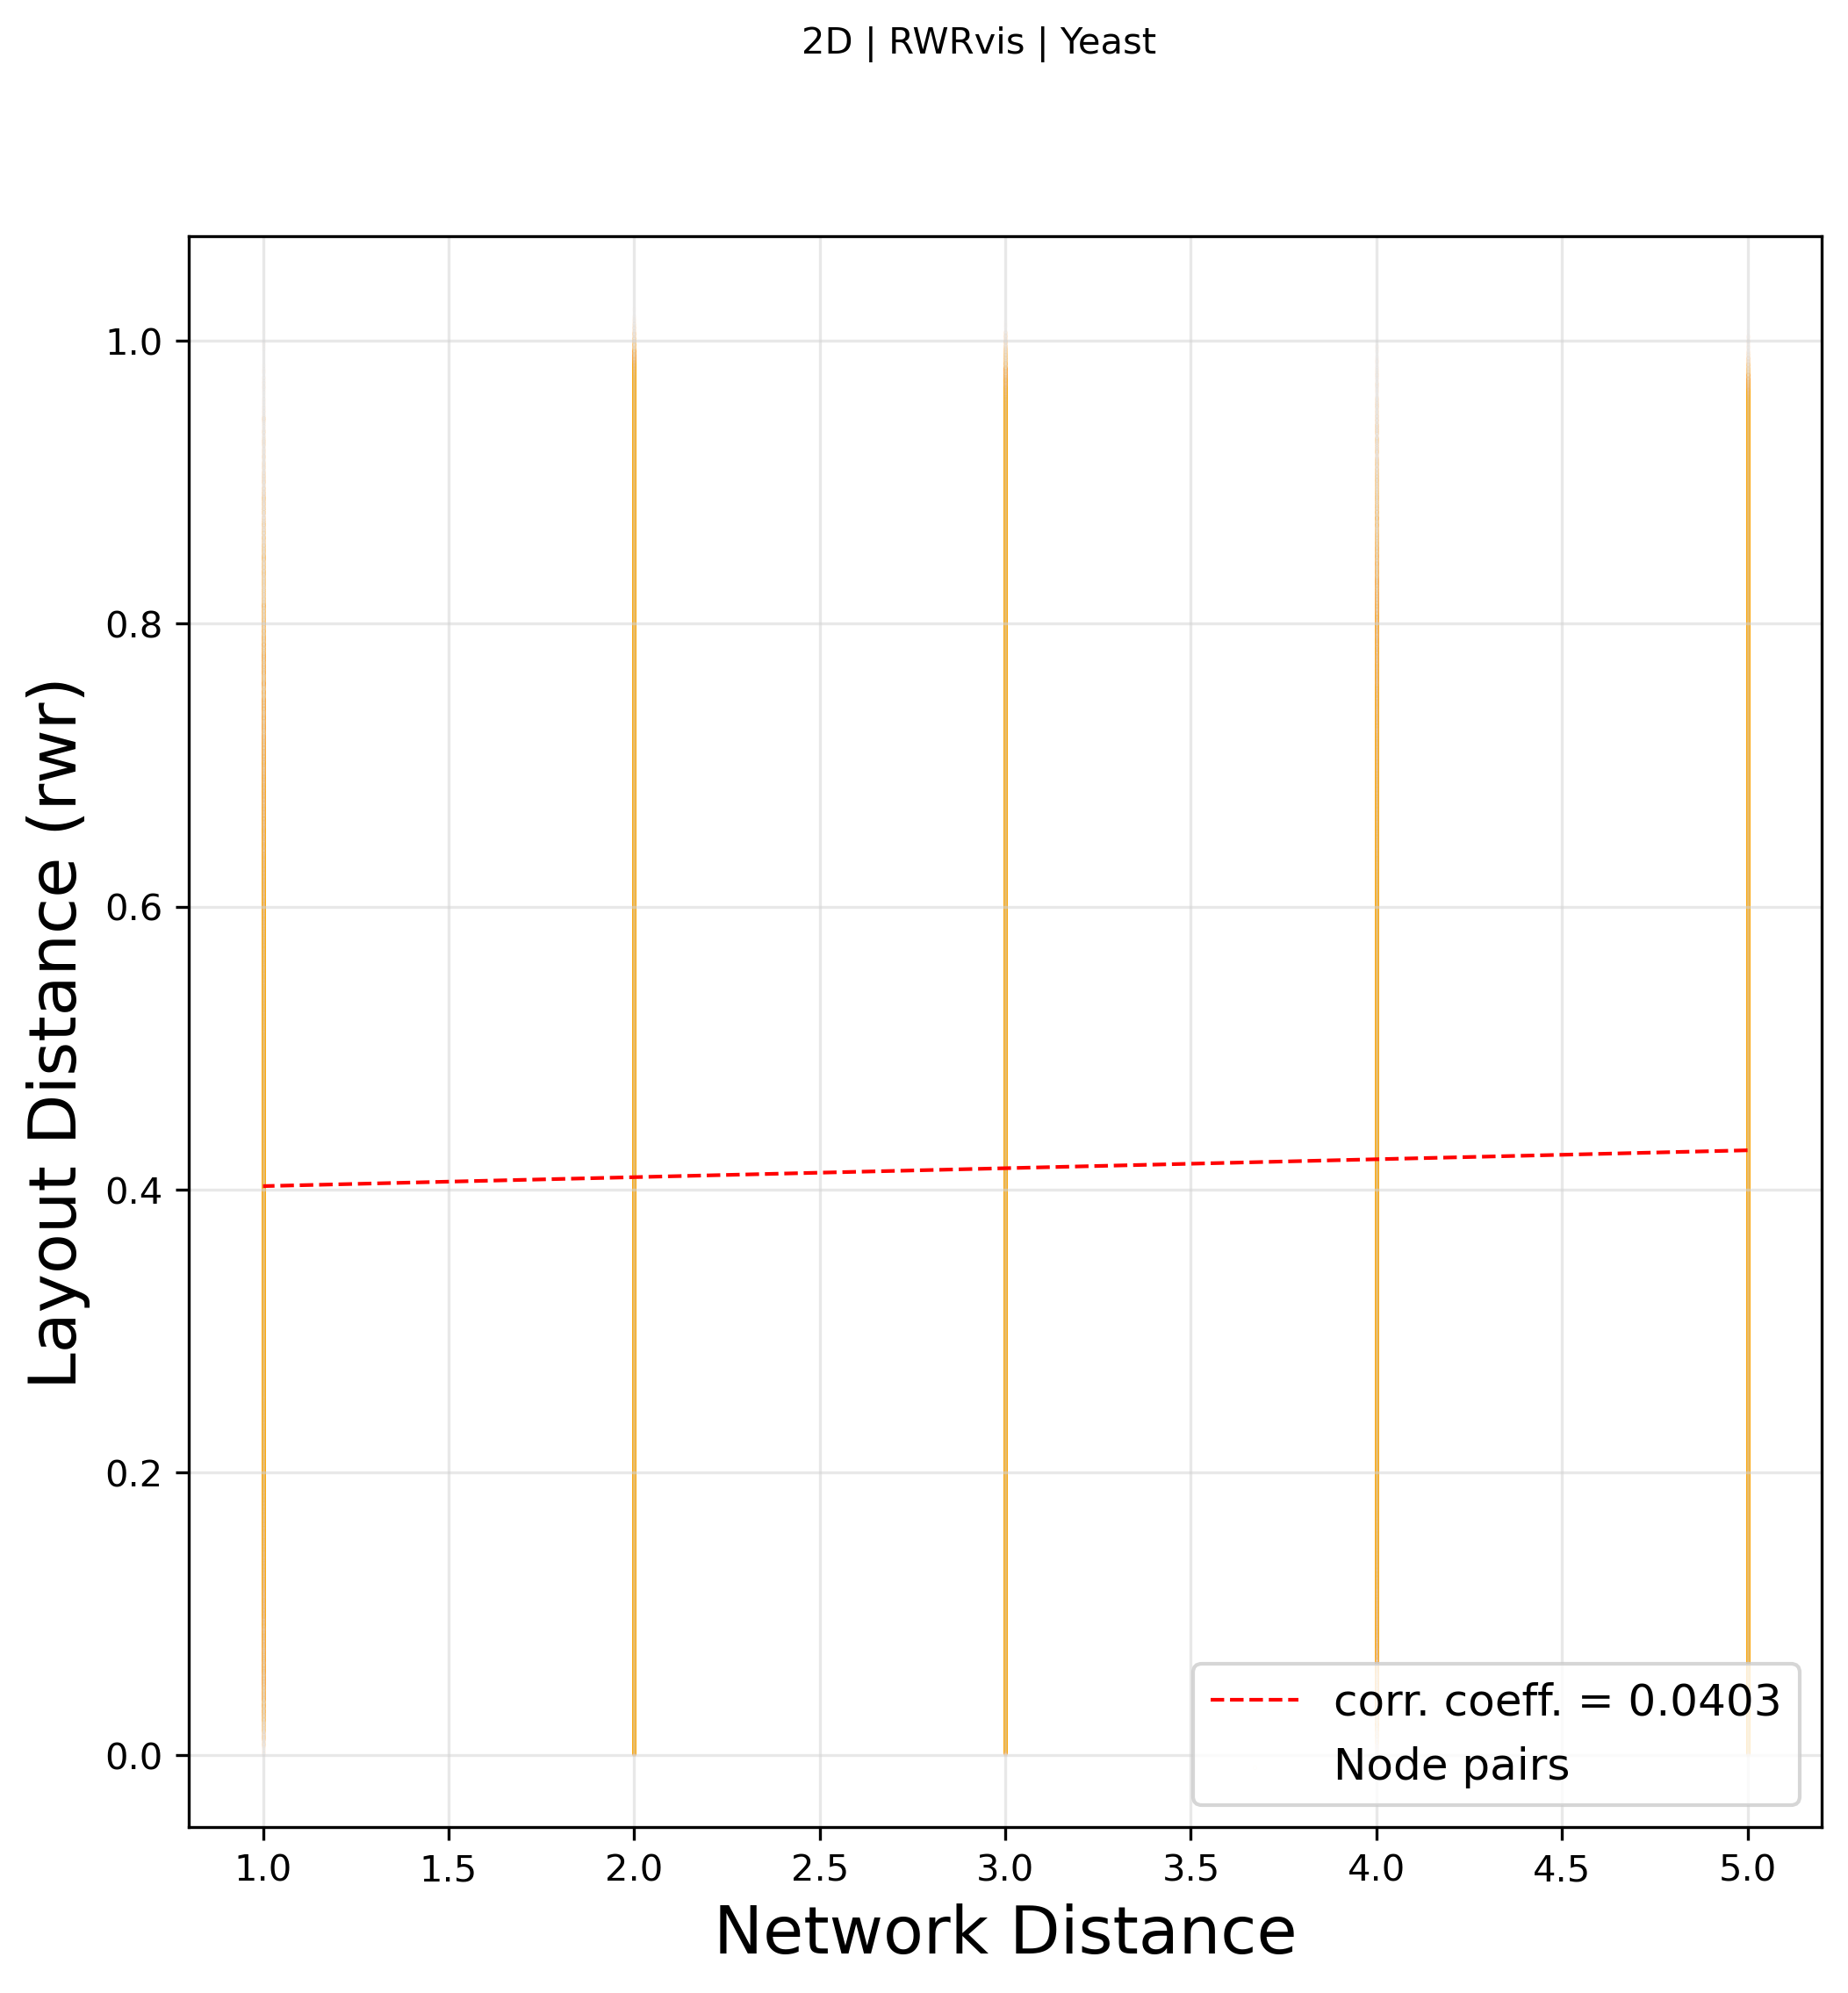

In [416]:
posG_complete_umap = posG_complete_umap_rwr_norm 

dist_layout2D = {}
for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

fig = plt.figure(figsize=(8,8), dpi=300)

y_layout = list(dist_layout2D.values())
x_layout = list(dist_network2D.values())
x_layout = list(dist_network2D_mod.values())
plt.scatter(x_layout,y_layout, c = 'orange', s = 0.00005, alpha = 0.5)

# REGRESSION LINE 
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)

mn_layout = min(x_layout)
mx_layout = max(x_layout)
x1_layout=np.linspace(mx_layout,mn_layout,1000)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)
plt.legend(('corr. coeff. = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

plt.show()
fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+metric+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

## 2D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

In [394]:
# SPRING DISTANCE
posG_spring2D = nx.spring_layout(G, iterations = 50, dim = 2)
df_posG = pd.DataFrame(posG_spring2D).T
x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)
posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

dist_spring2D = {} 
for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

# LAYOUT DISTANCE
dist_layout2D = {} 
for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

df_boxplot_ = pd.DataFrame()
df_boxplot_['Spring Layout Distances'] = dist_spring2D.values()
df_boxplot_['Global Layout Distances'] = dist_layout2D.values()
df_boxplot_melt = pd.melt(df_boxplot_)
df_boxplot_melt.columns = ['variable','Layout Distances']

fig = plt.figure(figsize =(16,12), dpi=300)

pal = {"Spring Layout Distances": "lightblue", "Global Layout Distances": "orange"}
boxplot = sns.boxplot(data=df_boxplot_melt, x=2*(list(dist_network2D.values())), y='Layout Distances', hue='variable', palette = pal,  fliersize = 0.001, notch=False, linewidth=1.0)
    
boxplot.set_xlabel("Network Distances", fontsize=24)
boxplot.set_ylabel("Layout Distances", fontsize=24)
boxplot.set_title('2D | Network vs. Layout Distances | '+organism,  y=1.05,  fontsize=20)

boxplot.get_legend().set_visible(False)
#plt.legend(bbox_to_anchor=(1, 0), loc=4, borderaxespad=0.5, fontsize=12);
plt.savefig('output_plots/BoxplotDistances_spring_rwr_'+organism+'.png')

plt.show()

+ FEATURE MATRIX = CENTRALITIES

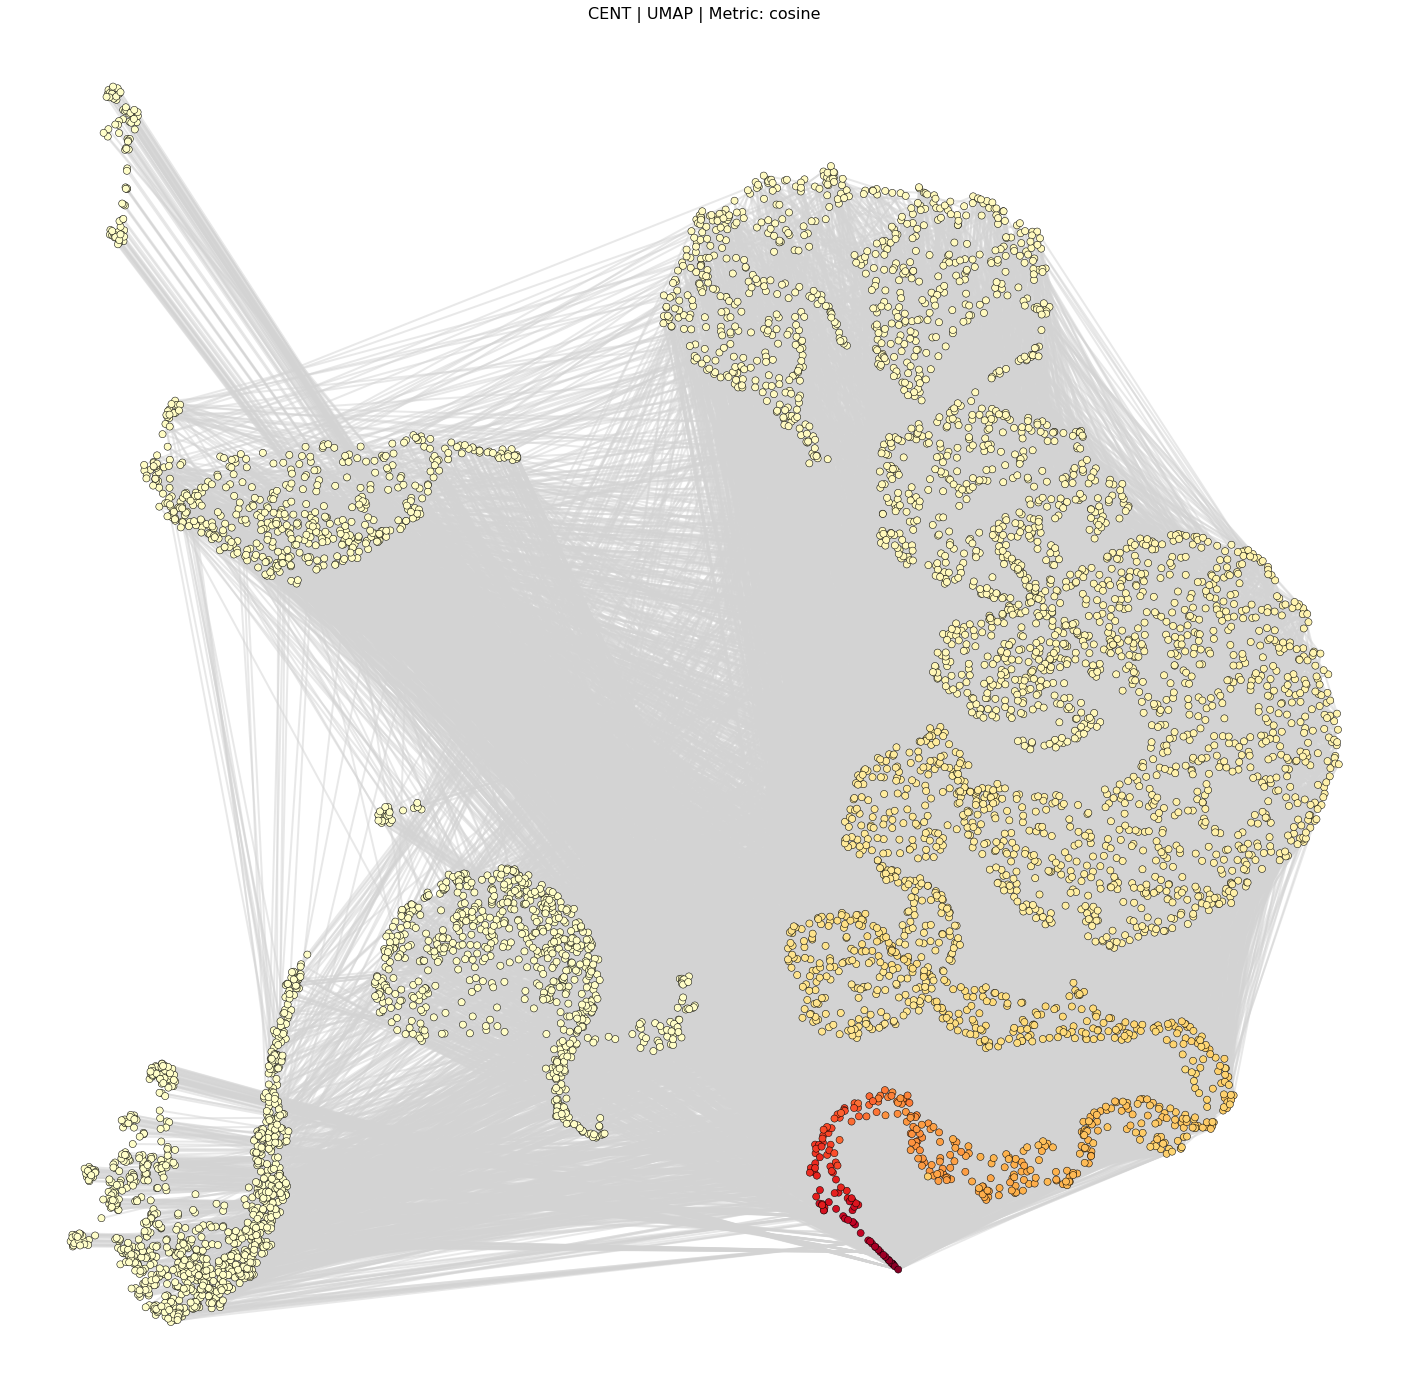

CPU times: user 27.3 s, sys: 417 ms, total: 27.7 s
Wall time: 21.7 s


In [23]:
%%time 

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.9 #defines how dense points are stacked together 
metric ='cosine'

feature = 'CENT'

umap_cent = embed_umap_2D(DM_cent, n_neighbors, spread, min_dist, metric)

posG_umap_cent = get_posG_2D(list(G.nodes()), umap_cent)
posG_complete_umap_cent = {key:posG_umap_cent[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_cent).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_cent_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_cent_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 50, #100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_cent_norm, width = edge_width, 
                       edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

_________

# EVALUATION - 2D


# PARAMETER TESTING for high Correlation Coefficients 

### SPRING 

In [103]:
dist_network2D = dist_network2D_mod

In [109]:
feature = 'spring'
    
iterationslist = [10,50,100,500] #,3000,4000,5000]

d_walltimes = {}
d_r_values = {}

for i in iterationslist:
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = i, dim = 2)
    
    df_posG = pd.DataFrame(posG_spring2D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    
    end = time.time()
    print('Spring iter:', i)
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    print('----------------')
    
    walltime = s+m*60
    d_walltimes[i] = walltime
    
    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network2D.values())
    
    gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_r_values[i] = r_value_spring

Spring iter: 10
Execution Time: 00:00:21
min: 0 sec: 21
----------------
Spring iter: 50
Execution Time: 00:01:07
min: 1 sec: 7
----------------
Spring iter: 100
Execution Time: 00:02:10
min: 2 sec: 10
----------------
Spring iter: 500
Execution Time: 00:11:08
min: 11 sec: 8
----------------
Spring iter: 1000
Execution Time: 00:21:30
min: 21 sec: 30
----------------


In [110]:
d_r_values

{10: 0.2379707169642622,
 50: 0.23559646516879815,
 100: 0.19425681497610436,
 500: 0.238055966672939,
 1000: 0.23195452080070864}

In [111]:
d_walltimes

{10: 21, 50: 67, 100: 130, 500: 668, 1000: 1290}

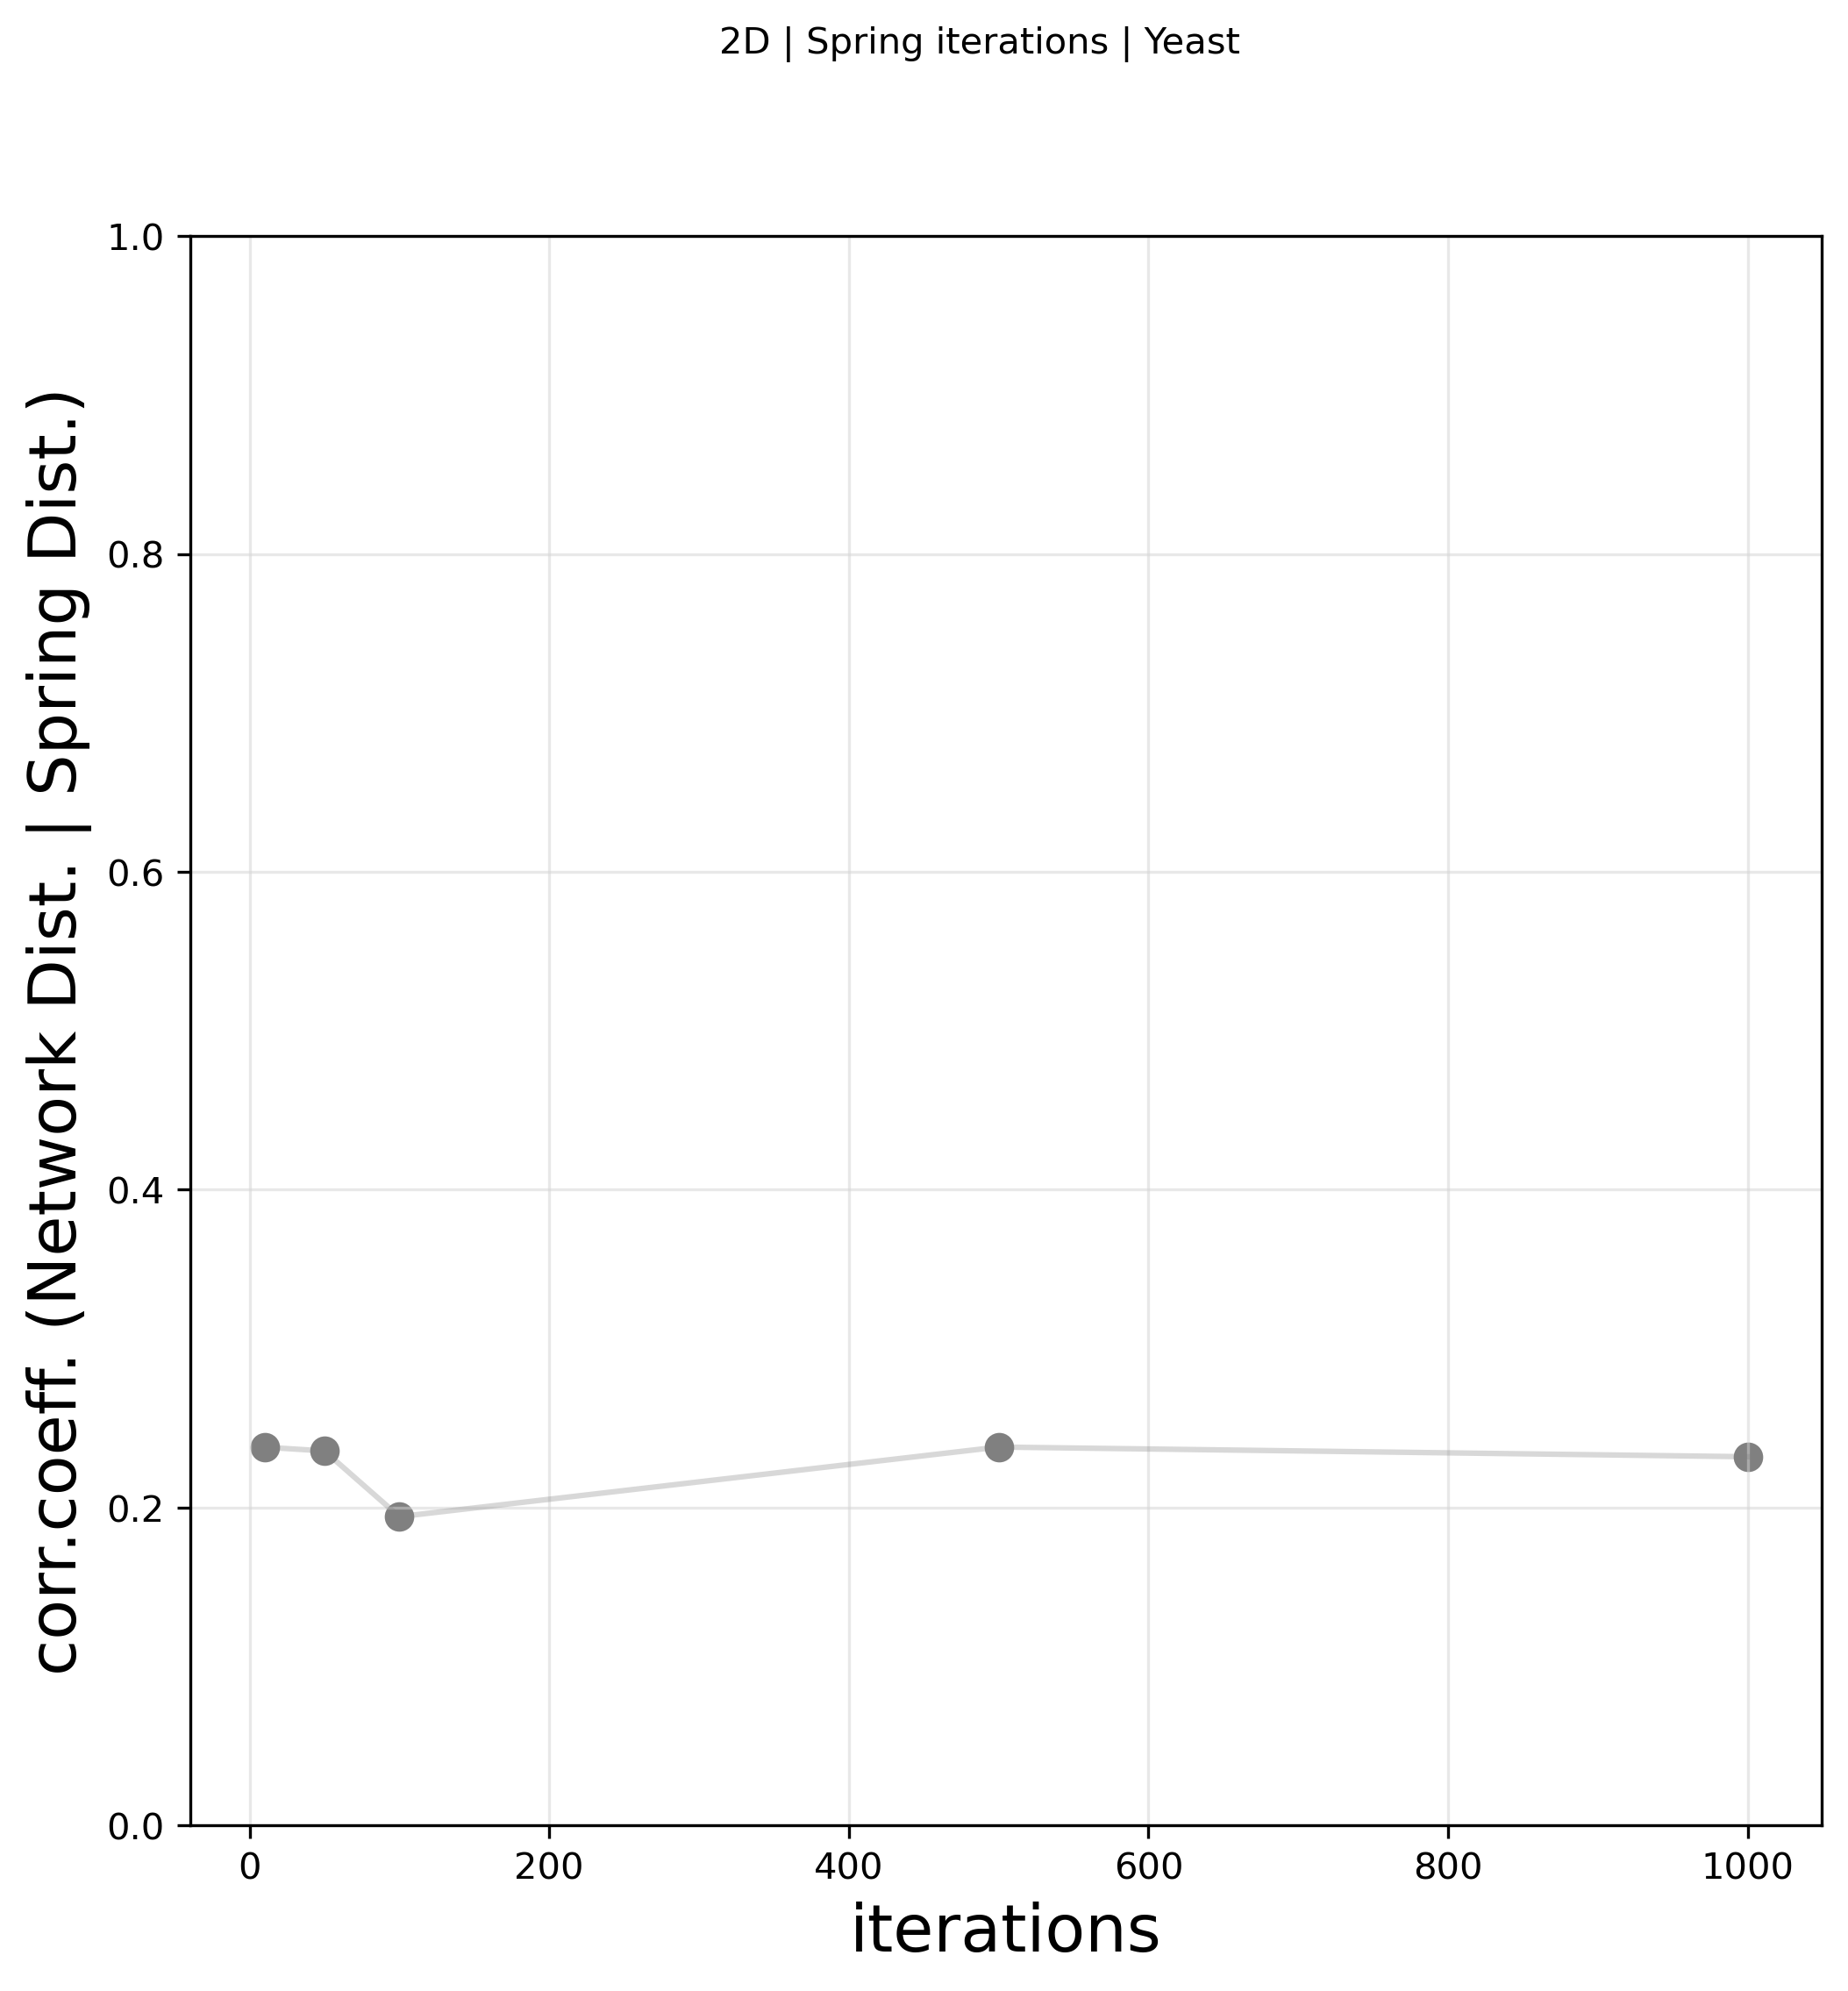

In [112]:
x_corr_spring = list(d_walltimes.keys())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("iterations", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0 ,ymax=1.0)

fig.savefig('output_plots/Correlation_'+feature+'_'+organism+'.png')

In [113]:
x_corr_spring = list(d_walltimes.values())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("Time [seconds]", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation_Time_'+feature+'_'+organism+'.png')

### UMAP - RWR

### Impact of UMAP PARAMETERS to CORRELATION COEFFICIENT (of Network Dist / Layout Dist) 
+ number of neighbors 
+ n_epochs
+ learning rate 
+ spread 
+ min_dist

In [314]:
feature = 'RWRvis'

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 50
spread = 1
min_dist = 0.0

metric ='cosine'
lnr = 1 
nep = None

#### ------ NUMBER OF NEIGHBORS ------
+ The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation
+ Larger values result in more global views of the manifold, while smaller values result in more local data being preserved 
+ In general values should be in the range 2 to 100.

In [315]:
# NUMBER OF NEIGHBORS 

n_neighbor_list = [8,12,20,50,100,500]

d_rwr_neigh = {}
d_r_values_rwr_neigh = {}

for i in n_neighbor_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr = embed_umap_2D(DM_rwr, i, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP n_neighs:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_neigh[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network2D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_neigh[i] = r_value_rwr

UMAP n_neighs: 8
Execution Time: 00:00:25
min: 0 sec: 25
UMAP n_neighs: 12
Execution Time: 00:00:30
min: 0 sec: 30
UMAP n_neighs: 20
Execution Time: 00:00:24
min: 0 sec: 24
UMAP n_neighs: 50
Execution Time: 00:00:31
min: 0 sec: 31
UMAP n_neighs: 100
Execution Time: 00:00:54
min: 0 sec: 54
UMAP n_neighs: 500
Execution Time: 00:01:37
min: 1 sec: 37


In [316]:
d_r_values_rwr_neigh

{8: -0.015352474723364913,
 12: 0.08905447379873176,
 20: 0.011454447250779853,
 50: 0.04858490687868888,
 100: 0.035173982081384426,
 500: 0.05319879418184711}

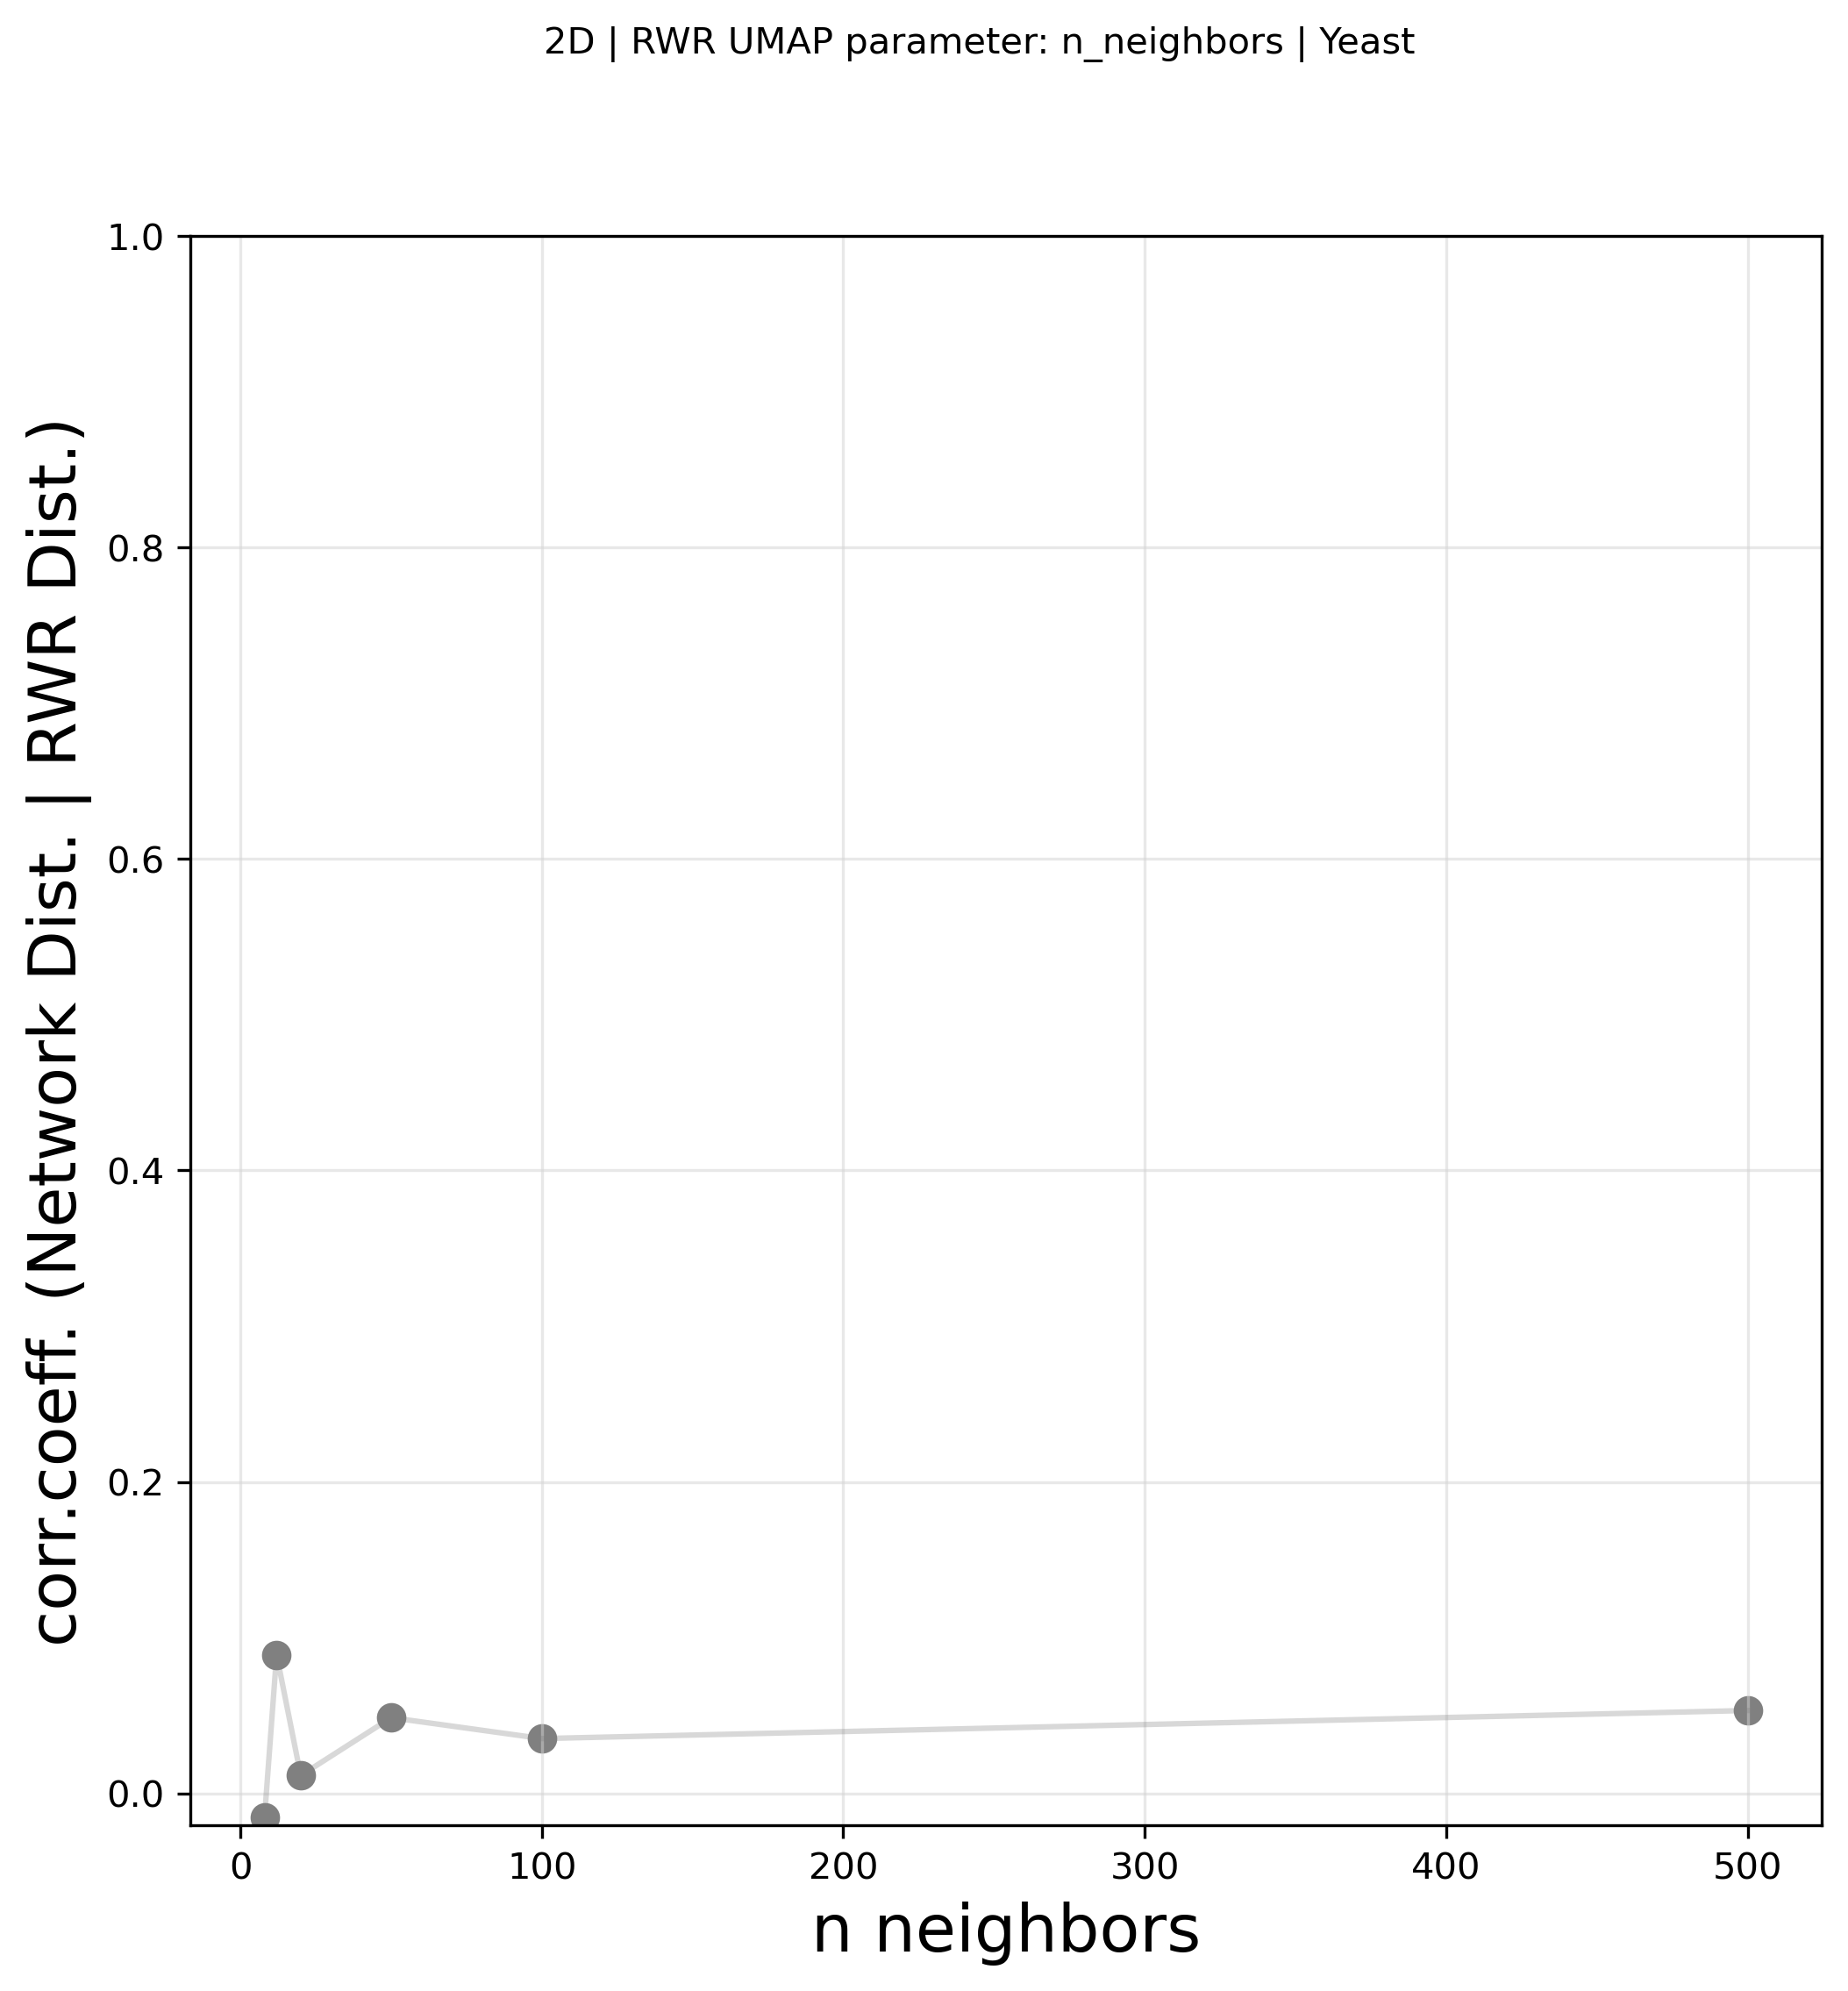

In [317]:
x = list(d_rwr_neigh.keys())
y = list(d_r_values_rwr_neigh.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("n neighbors", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: n_neighbors | '+organism, fontsize=10)
plt.ylim(#ymin=0, 
    ymax=1.0)

fig.savefig('output_plots/Correlation2D_neighs_'+feature+'_'+organism+'.png')

In [325]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 12 #150
spread = 10.0
min_dist = 0.0

metric ='cosine'
lnr = 1
nep = None

#### ------ MIN DIST ------
+ The effective minimum distance between embedded points
+ Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points

In [327]:
# MIN DIST 

mindist_list = [0.0,0.1,0.9,1]
#mindist_list = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]


d_rwr_mdist = {}
d_r_values_rwr_mdist = {}

for i in mindist_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, i, metric, learn_rate = lnr, n_ep = nep)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP min dist:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_mdist[i] = walltime_rwr
     
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network2D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_mdist[i] = r_value_rwr

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 0.0
Execution Time: 00:00:16
min: 0 sec: 16


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 0.1
Execution Time: 00:00:17
min: 0 sec: 17


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 0.9
Execution Time: 00:00:16
min: 0 sec: 16


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 1
Execution Time: 00:00:16
min: 0 sec: 16


In [328]:
d_r_values_rwr_mdist

{0.0: 0.09378768945503044,
 0.1: 0.09228498226223901,
 0.9: 0.09930578324232443,
 1: 0.09574012672813478}

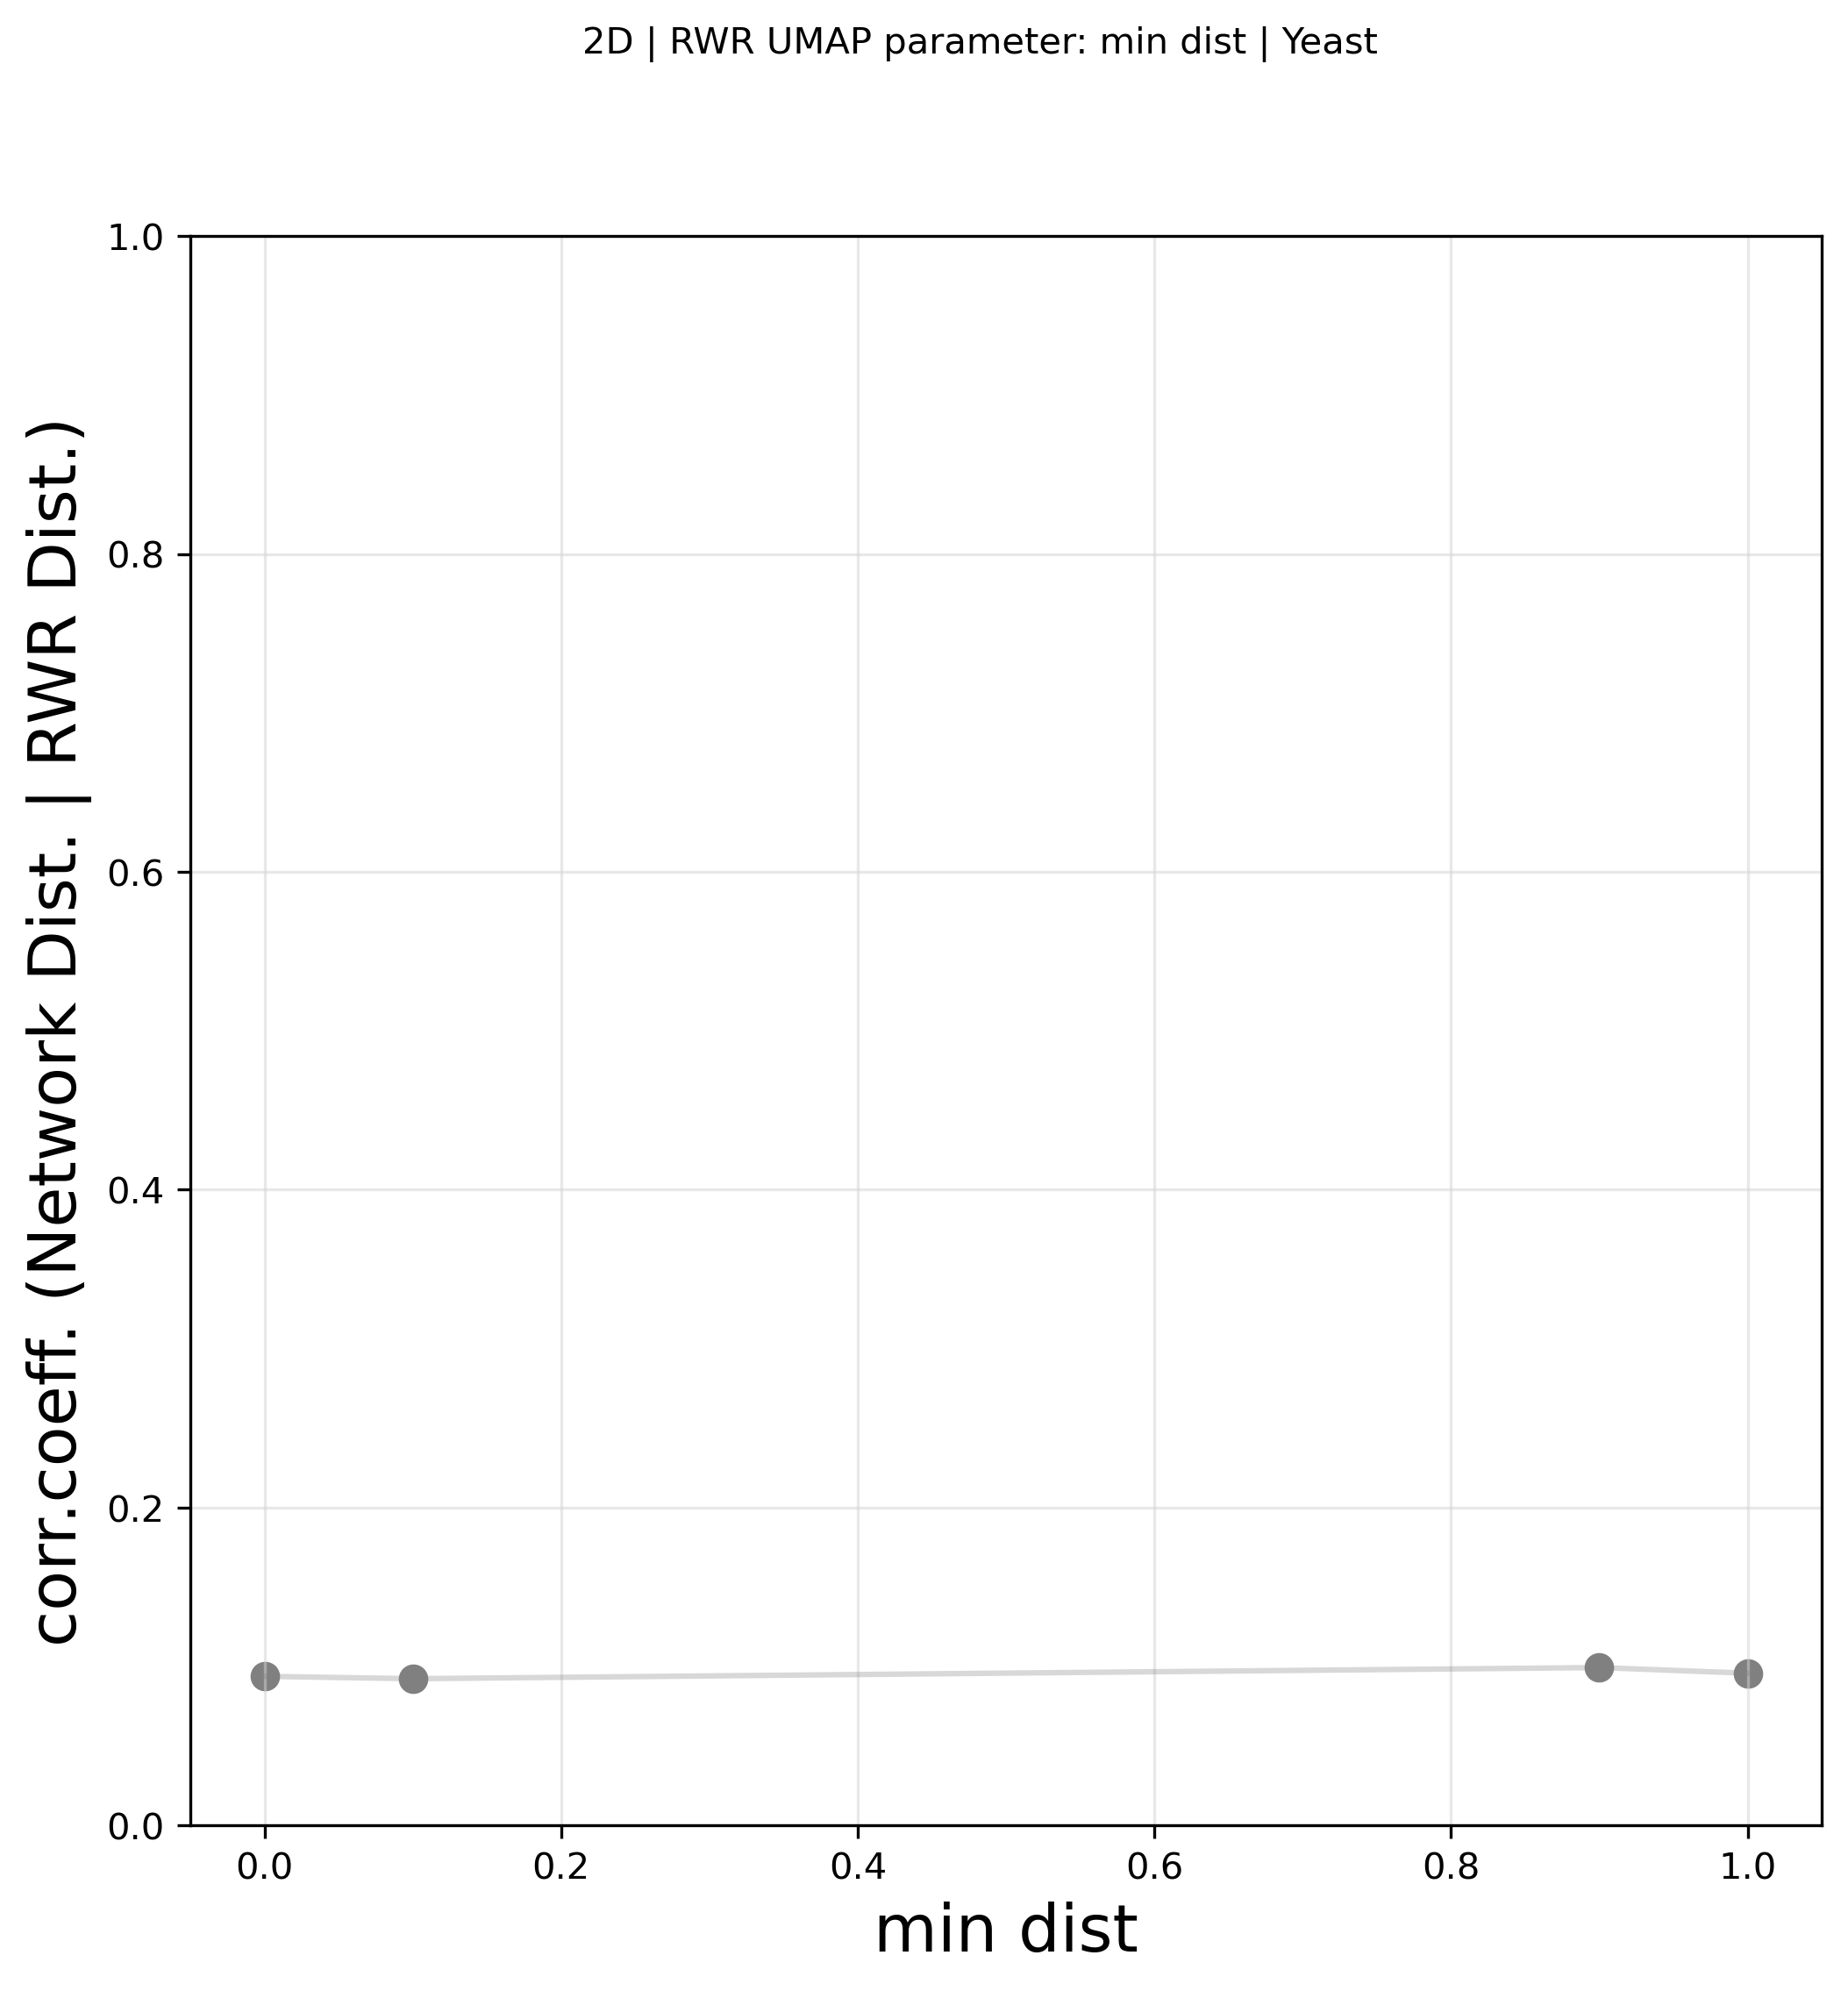

In [329]:
x = list(d_rwr_mdist.keys())
y = list(d_r_values_rwr_mdist.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("min dist", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: min dist | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation_mindist_'+feature+'_'+organism+'.png')

In [330]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 12
spread = 10
min_dist = 0.9

metric ='cosine'
lnr = 1
nep = None

#### ------ SPREAD ------
+ The effective scale of embedded points
+ In combination with min_dist this determines how clustered/clumped the embedded points are

In [331]:
# SPREAD

spread_list = [0.9,1,10,50]

d_rwr_spread = {}
d_r_values_rwr_spread  = {}

for i in spread_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, i, min_dist, metric, learn_rate = lnr, n_ep = nep)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP spread:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_spread[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network2D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_spread[i] = r_value_rwr

UMAP spread: 0.9
Execution Time: 00:00:16
min: 0 sec: 16
UMAP spread: 1
Execution Time: 00:00:24
min: 0 sec: 24


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 10
Execution Time: 00:00:21
min: 0 sec: 21


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 50
Execution Time: 00:00:18
min: 0 sec: 18


In [332]:
d_rwr_spread

{0.9: 16, 1: 24, 10: 21, 50: 18}

In [333]:
d_r_values_rwr_spread

{0.9: 0.05408038749577672,
 1: 0.058812955005122076,
 10: 0.09930578324232443,
 50: -0.026542635056625494}

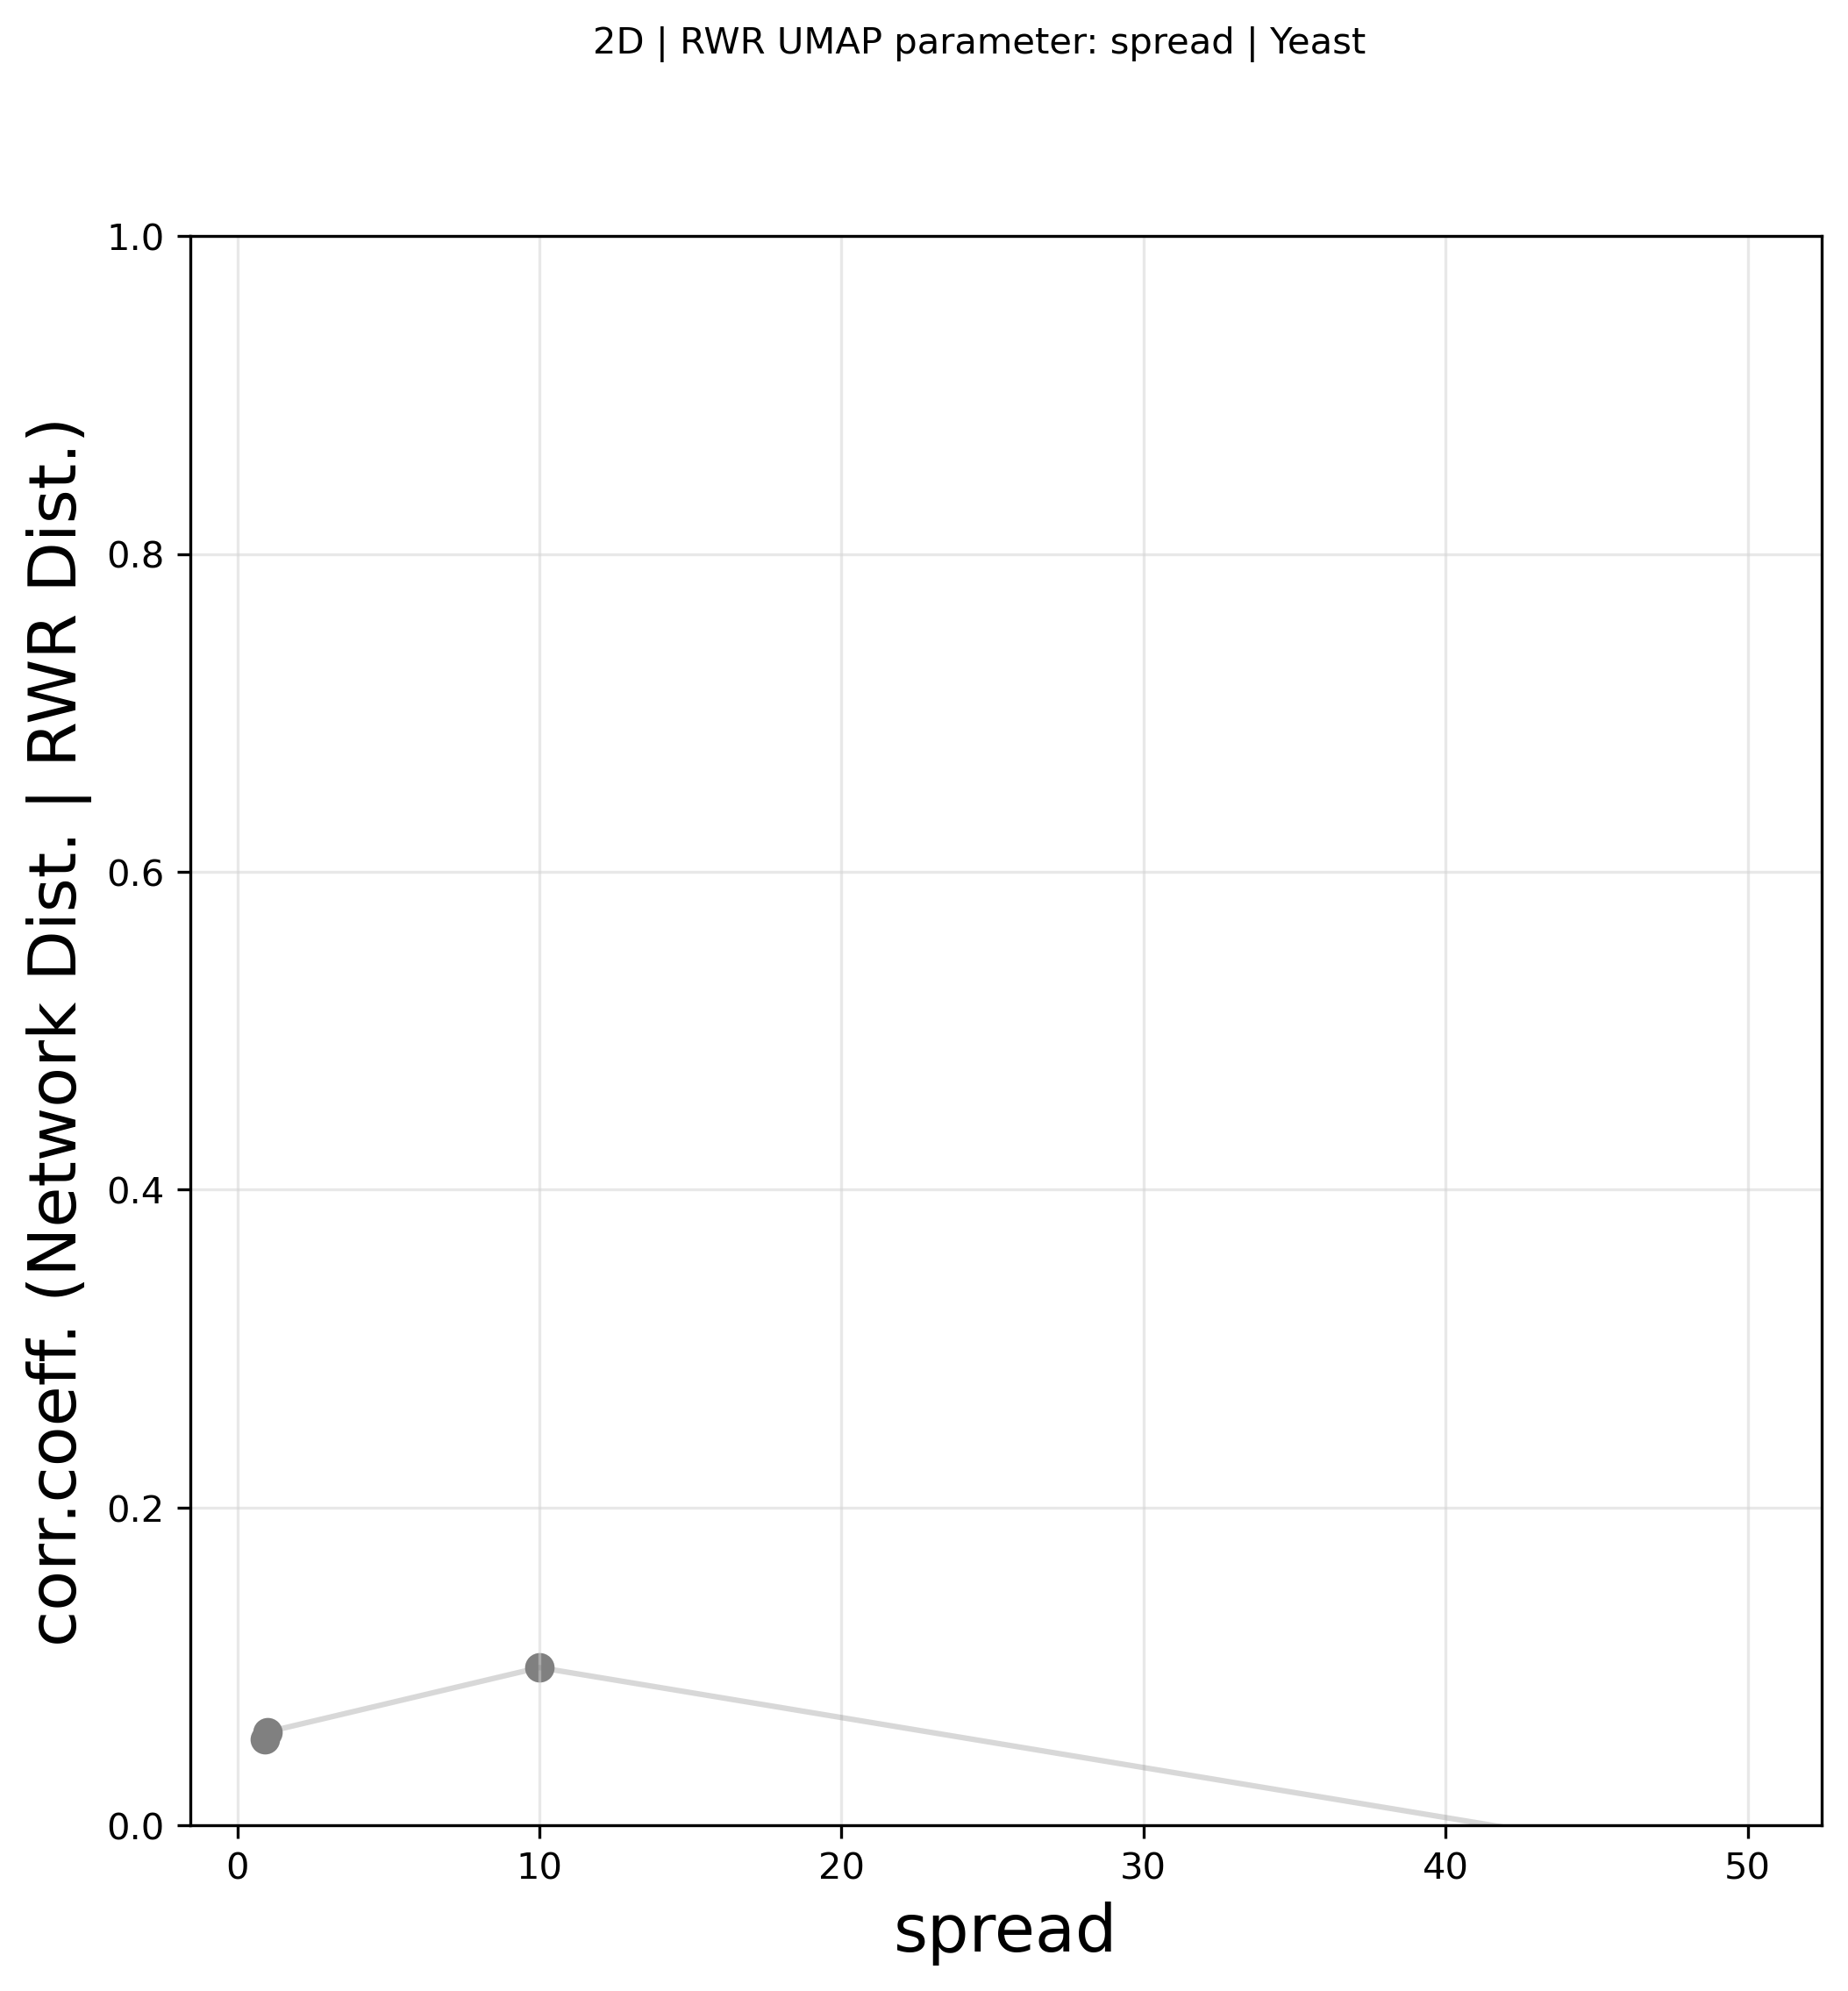

In [334]:
x = list(d_rwr_spread.keys())
y = list(d_r_values_rwr_spread.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("spread", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: spread | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation_spread_'+feature+'_'+organism+'.png')

In [ ]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 12
spread = 10
min_dist = 0.9

metric = 'cosine'
lnr = 1
nep = None

#### ------ NUMBER OF EPOCHS ------
+ The number of training epochs to be used in optimizing the low dimensional embedding
+ Larger values result in more accurate embeddings 
+ If None is specified a value will be selected based on the size of the input dataset (200 for large datasets, 500 for small)

In [335]:
# NUMBER OF EPOCHS 

nep_list = [None, 100, 500, 1000]

d_rwr_epochs = {}
d_r_values_rwr_nep = {}

for i in nep_list: 
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = i)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP n_epoch:' ,i) 
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_epochs[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network2D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_nep[i] = r_value_rwr

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: None
Execution Time: 00:00:22
min: 0 sec: 22


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 100
Execution Time: 00:00:14
min: 0 sec: 14


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 500
Execution Time: 00:00:22
min: 0 sec: 22


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 1000
Execution Time: 00:00:24
min: 0 sec: 24


In [336]:
d_rwr_epochs

{None: 22, 100: 14, 500: 22, 1000: 24}

In [337]:
d_r_values_rwr_nep

{None: 0.09930578324232443,
 100: 0.04537985270459407,
 500: 0.09930578324232443,
 1000: 0.08337420903587897}

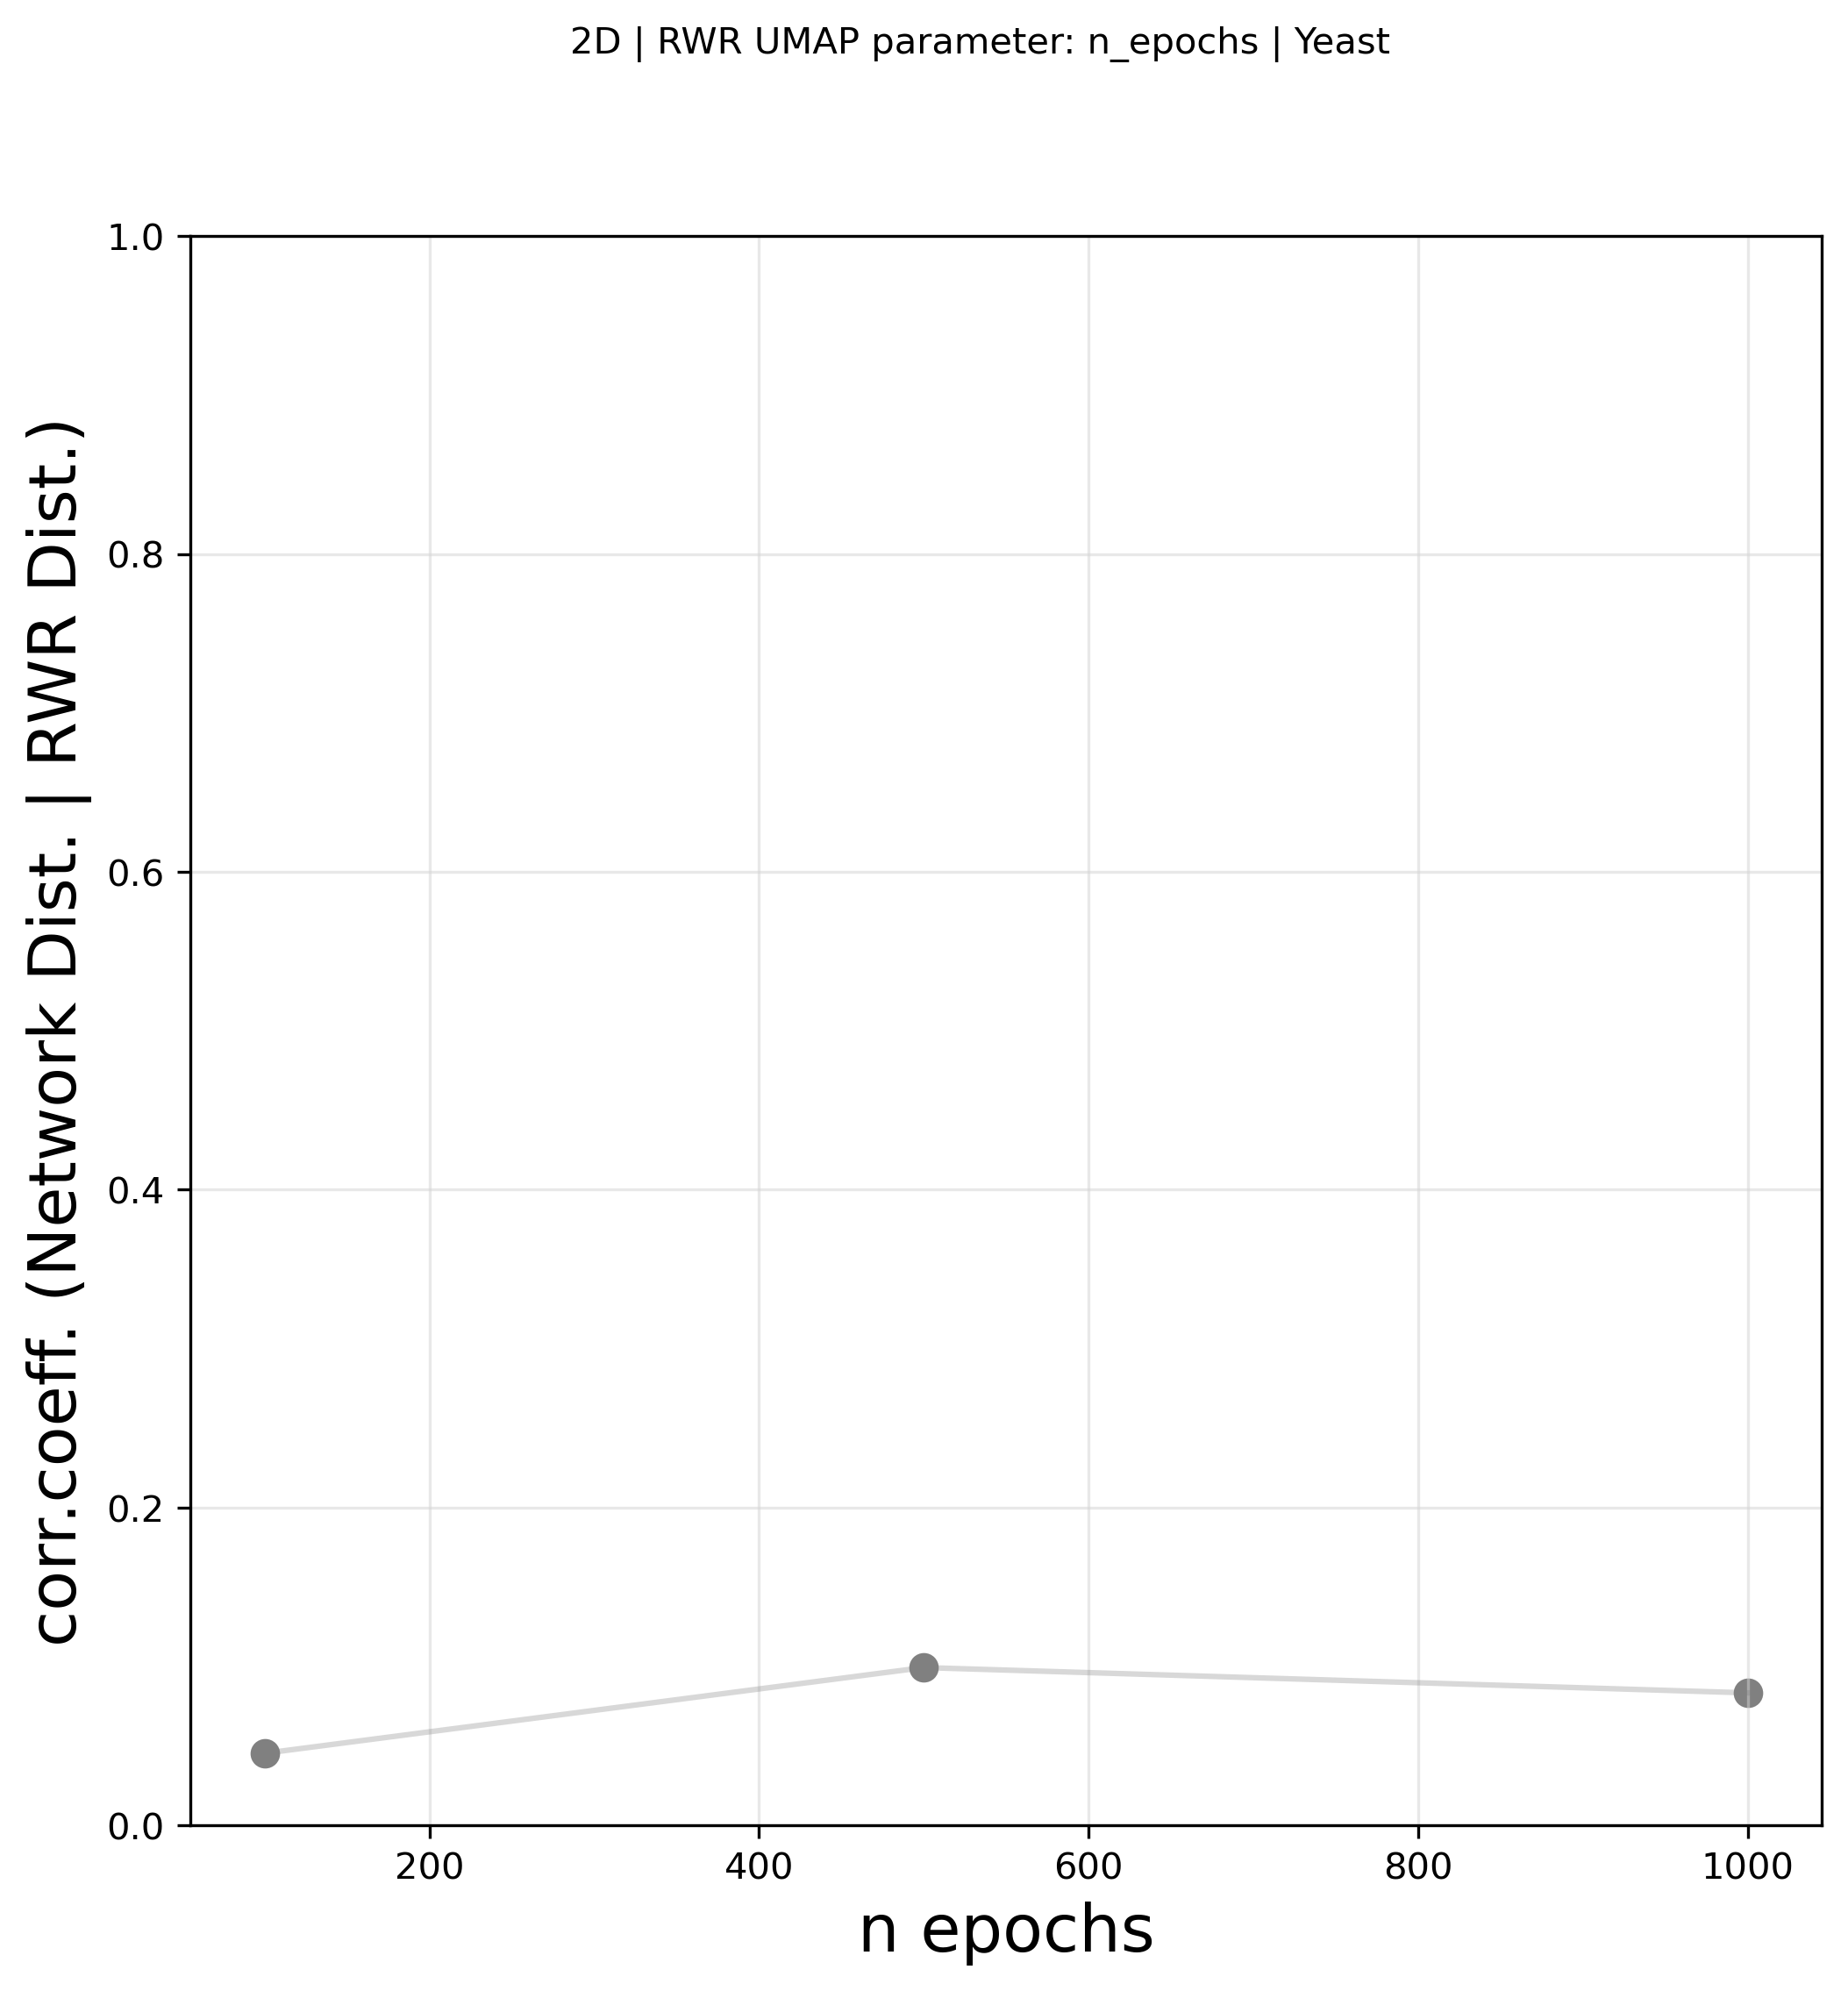

In [338]:
x = list(d_rwr_epochs.keys())
y = list(d_r_values_rwr_nep.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("n epochs", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: n_epochs | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation_nepochs_'+feature+'_'+organism+'.png')

In [398]:
#adjust parameters 

#-----------------------------
# INITIAL UMAP PARAMETERS:
#-----------------------------
n_neighbors = 10
spread = 10
min_dist = 0.5

metric = 'cosine'
lnr = 1
nep = None

#### ------ LEARNING RATE ------
+ The initial learning rate for the embedding optimization

In [399]:
# LEARNING RATE 

lnr_list = [0.01,0.1,1,10,100]

d_rwr_lnr = {}
d_r_values_rwr_lnr = {}

for i in lnr_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = i, n_ep = nep)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP learning rate:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_lnr[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network2D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_lnr[i] = r_value_rwr

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 0.01
Execution Time: 00:01:26
min: 1 sec: 26


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 0.1
Execution Time: 00:00:32
min: 0 sec: 32


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 1
Execution Time: 00:00:20
min: 0 sec: 20


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 10
Execution Time: 00:00:14
min: 0 sec: 14


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 100
Execution Time: 00:00:19
min: 0 sec: 19


In [400]:
d_rwr_lnr

{0.01: 86, 0.1: 32, 1: 20, 10: 14, 100: 19}

In [401]:
d_r_values_rwr_lnr

{0.01: -0.08484930701794967,
 0.1: 0.0022695067280883875,
 1: 0.04224163259703296,
 10: 0.02347930433445832,
 100: 0.03066600449618009}

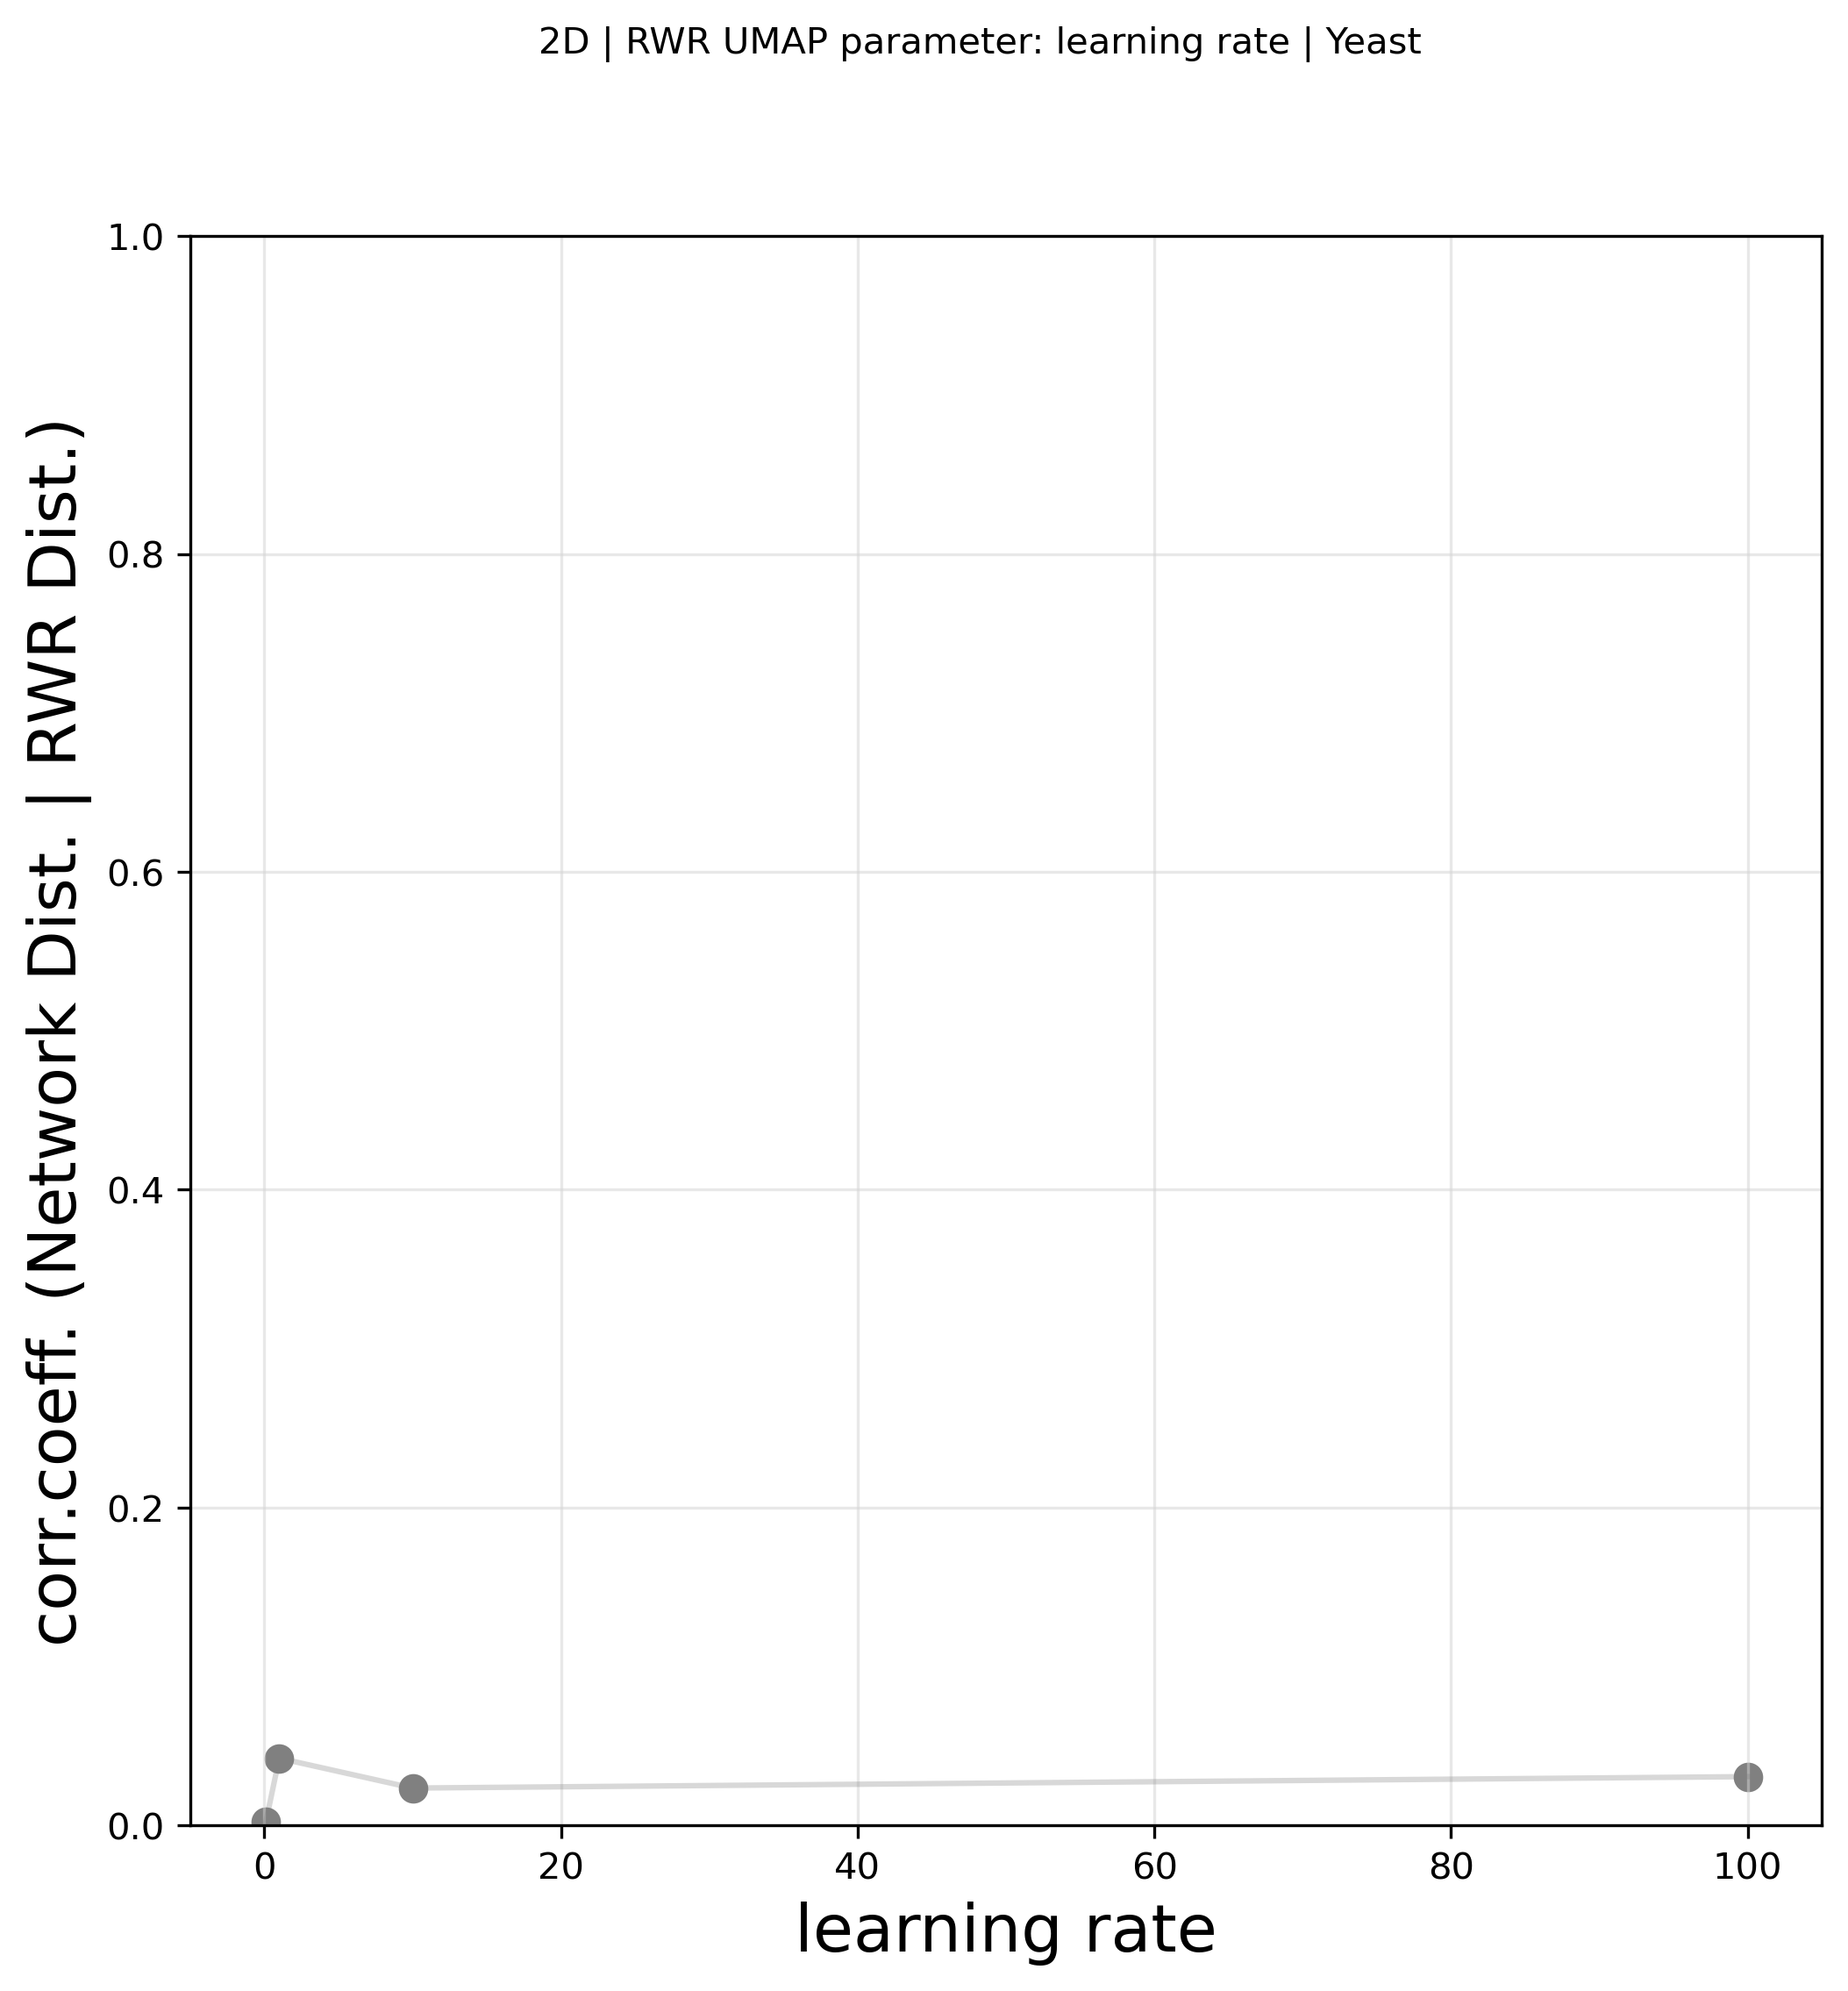

In [402]:
x = list(d_rwr_lnr.keys())
y = list(d_r_values_rwr_lnr.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("learning rate", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: learning rate | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation_learnrate_'+feature+'_'+organism+'.png')

# 3D 

___________
## NETWORK DISTANCE 
___________

In [9]:
dist_network3D = dist_network2D #_mod 

## SPRING

In [10]:
%%time 

posG_spring3D = nx.spring_layout(G, iterations = 50, dim = 3)

df_posG = pd.DataFrame(posG_spring3D).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

spring_nodes = get_trace_nodes_3D(posG_spring3D_norm, None, colours, 2, opac = 0.9) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D_norm, edge_colorlight, 0.1) 

spring_data = [spring_nodes, spring_edges]

print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=True)

NameError: name 'colours' is not defined

## 3D PORTRAITS 

+ ADJACENCIES

In [975]:
%%time 
n_neighbors = 20 #deg_mean # balance between local and global structure in the data
spread = 1.0
min_dist = 0.01 #defines how dense points are stacked together 
metric ='cosine'
lnr = 1
nep = None

feature = 'ADJ'

A = nx.adjacency_matrix(G)
adj = A.toarray()
DM_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))

umap_3D_adj = embed_umap_3D(DM_adj, n_neighbors, spread, min_dist, metric, lnr, nep)

posG_3Dumap_adj = get_posG_3D(list(G.nodes()), umap_3D_adj)
posG_3D_complete_umap_adj = {key:posG_3Dumap_adj[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_adj).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_adj_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_adj_nodes = get_trace_nodes_3D(posG_3D_complete_umap_adj_norm, None, colours, 4, opac = 0.9) # size3d)
umap_adj_edges = get_trace_edges_3D(G, posG_3D_complete_umap_adj_norm, edge_colorlight, 0.1) 

umap_adj_data = [umap_adj_edges, umap_adj_nodes]

fig = pgo.Figure()
for i in umap_adj_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

CPU times: user 7.85 s, sys: 910 ms, total: 8.76 s
Wall time: 9.99 s


'output_plots/3Dtoynetwork_umap_ADJ_grid.html'

+ RANDOM WALK - visiting probability

In [11]:
##############################
# Y E A S T
##############################

n_neighbors = 10
spread = 10
min_dist = 0.5

metric = 'cosine'
lnr = 1
nep = None


##############################
# H U M A N  
##############################

n_neighbors = 20
spread = 1
min_dist = 0.1

metric = 'cosine'
lnr = 1
nep = None

In [12]:
%%time 

feature = 'RWRvis'

r = .9
alpha = 1.0

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
DM_rwr = FM_m

umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, min_dist, metric, lnr, nep)

posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_rwr_nodes = get_trace_nodes_3D(posG_3D_complete_umap_rwr_norm, None, colours, 2, opac = 0.9) # size3d)
umap_rwr_edges = get_trace_edges_3D(G, posG_3D_complete_umap_rwr_norm, edge_colorlight, 0.1) 

umap_rwr_data = [umap_rwr_edges, umap_rwr_nodes]

fig = pgo.Figure()
for i in umap_rwr_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'_.html', auto_open=True)

NameError: name 'colours' is not defined

In [ ]:
posG_3D_complete_umap = posG_3D_complete_umap_rwr_norm 

# LAYOUT DISTANCE 
dist_layout3D = dict()
for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

fig = plt.figure(figsize=(8,8), dpi=300)

y_layout3D = list(dist_layout3D.values())
x_layout3D = list(dist_network3D.values())
plt.scatter(x_layout3D,y_layout3D, c = 'orange', s = 0.00005, alpha = 0.5)

# REGRESSION LINE 
gradient_layout3D, intercept_layout3D, r_value_layout3D, p_value_layout3D, std_err_layout3D = stats.linregress(x_layout3D,y_layout3D)
mn_layout3D=min(x_layout3D)
mx_layout3D=max(x_layout3D)
x1_layout3D=np.linspace(mn_layout3D,mx_layout3D,500)
line_layout3D = gradient_layout3D*x1_layout3D+intercept_layout3D
plt.plot(x1_layout3D,line_layout3D,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.legend(('corr. coeff. = {}'.format(round(r_value_layout3D,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.grid(True, c='lightgrey')

plt.suptitle('3D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout3D,intercept_layout3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')

## 3D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

In [1]:
# SPRING DISTANCE
posG_spring3D = nx.spring_layout(G, iterations = 10, dim = 3)
df_posG = pd.DataFrame(posG_spring3D).T
x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)
posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
         
print('start distance calculation')

dist_spring3D = dict()
for (id1,p1),(id2,p2) in it.combinations(posG_spring3D_norm.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

print('plot preparation')
    
# LAYOUT DISTANCE
#dist_layout3D = dict()
#for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap.items(),2):
#    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
#    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
df_boxplot_ = pd.DataFrame()
df_boxplot_['Spring Layout Distances'] = dist_spring3D.values()
df_boxplot_['Global Layout Distances'] = dist_layout3D.values()
df_boxplot_melt = pd.melt(df_boxplot_)
df_boxplot_melt.columns = ['variable','Layout Distances']

print('start plotting')

fig = plt.figure(figsize =(16,12), #(20,10), 
                 dpi=300)

pal = {"Spring Layout Distances": "lightblue", "Global Layout Distances": "orange"}
boxplot = sns.boxplot(data=df_boxplot_melt, x=2*(list(dist_network3D.values())), y='Layout Distances', hue='variable', palette = pal,  fliersize = 0.001, notch=False, linewidth=1.0)
    
boxplot.set_xlabel("Network Distances", fontsize=24)
boxplot.set_ylabel("Layout Distances", fontsize=24)
boxplot.set_title('3D | Network vs. Layout Distances | '+organism,  y=1.05,  fontsize=20)

boxplot.get_legend().set_visible(False)

plt.ylim(ymin=0)

#plt.legend(bbox_to_anchor=(1, 0), loc=4, borderaxespad=0.5, fontsize=12);
plt.savefig('output_plots/BoxplotDistances3D_spring_rwr_'+organism+'.png')

plt.show()

NameError: name 'nx' is not defined

+ CENTRALITIES

In [350]:
%%time 

n_neighbors = 6 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

feature = 'CENT'

umap_cent_3D = embed_umap_3D(DM_cent, n_neighbors, spread, min_dist, metric, lnr, nep)

posG_3Dumap_cent = get_posG_3D(list(G.nodes()), umap_cent_3D)
posG_3D_complete_umap_cent = {key:posG_3Dumap_cent[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_cent).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_cent_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_cent_nodes = get_trace_nodes_3D(posG_3D_complete_umap_cent_norm, None, colours, 4, opac = 0.8) # size3d)
umap_cent_edges = get_trace_edges_3D(G, posG_3D_complete_umap_cent_norm, edge_colordark, 1.0) 

umap_cent_data = [umap_cent_edges, umap_cent_nodes]

fig = pgo.Figure()
for i in umap_cent_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

CPU times: user 19.2 s, sys: 19.4 s, total: 38.6 s
Wall time: 47.7 s


'output_plots/3Dtoynetwork_umap_CENT_Yeast.html'

_________

# EVALUATION - 3D

# PARAMETER TESTING for high Correlation Coefficients 

### SPRING 

In [351]:
feature = 'spring'

iterationslist = [10,50,100,500]

d_walltimes = {}
d_r_values = {}

for i in iterationslist:
    
    start = time.time()
    posG_spring3D = nx.spring_layout(G, iterations = i, dim = 3)
    
    df_posG = pd.DataFrame(posG_spring3D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    
    end = time.time()
    print('Spring iter:', i)
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    print('----------------')
    
    walltime = s+m*60
    d_walltimes[i] = walltime
    
    dist_spring3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_spring3D_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_spring = list(dist_spring3D.values())
    x_spring = list(dist_network3D.values())
    
    gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_r_values[i] = r_value_spring

Spring iter: 10
Execution Time: 00:00:16
min: 0 sec: 16
----------------
Spring iter: 50
Execution Time: 00:01:08
min: 1 sec: 8
----------------
Spring iter: 100
Execution Time: 00:02:27
min: 2 sec: 27
----------------
Spring iter: 500
Execution Time: 00:11:06
min: 11 sec: 6
----------------


In [352]:
d_r_values

{10: 0.24872524316736958,
 50: 0.27687508987765186,
 100: 0.23624968044475197,
 500: 0.24327166978335618}

In [353]:
d_walltimes

{10: 16, 50: 68, 100: 147, 500: 666}

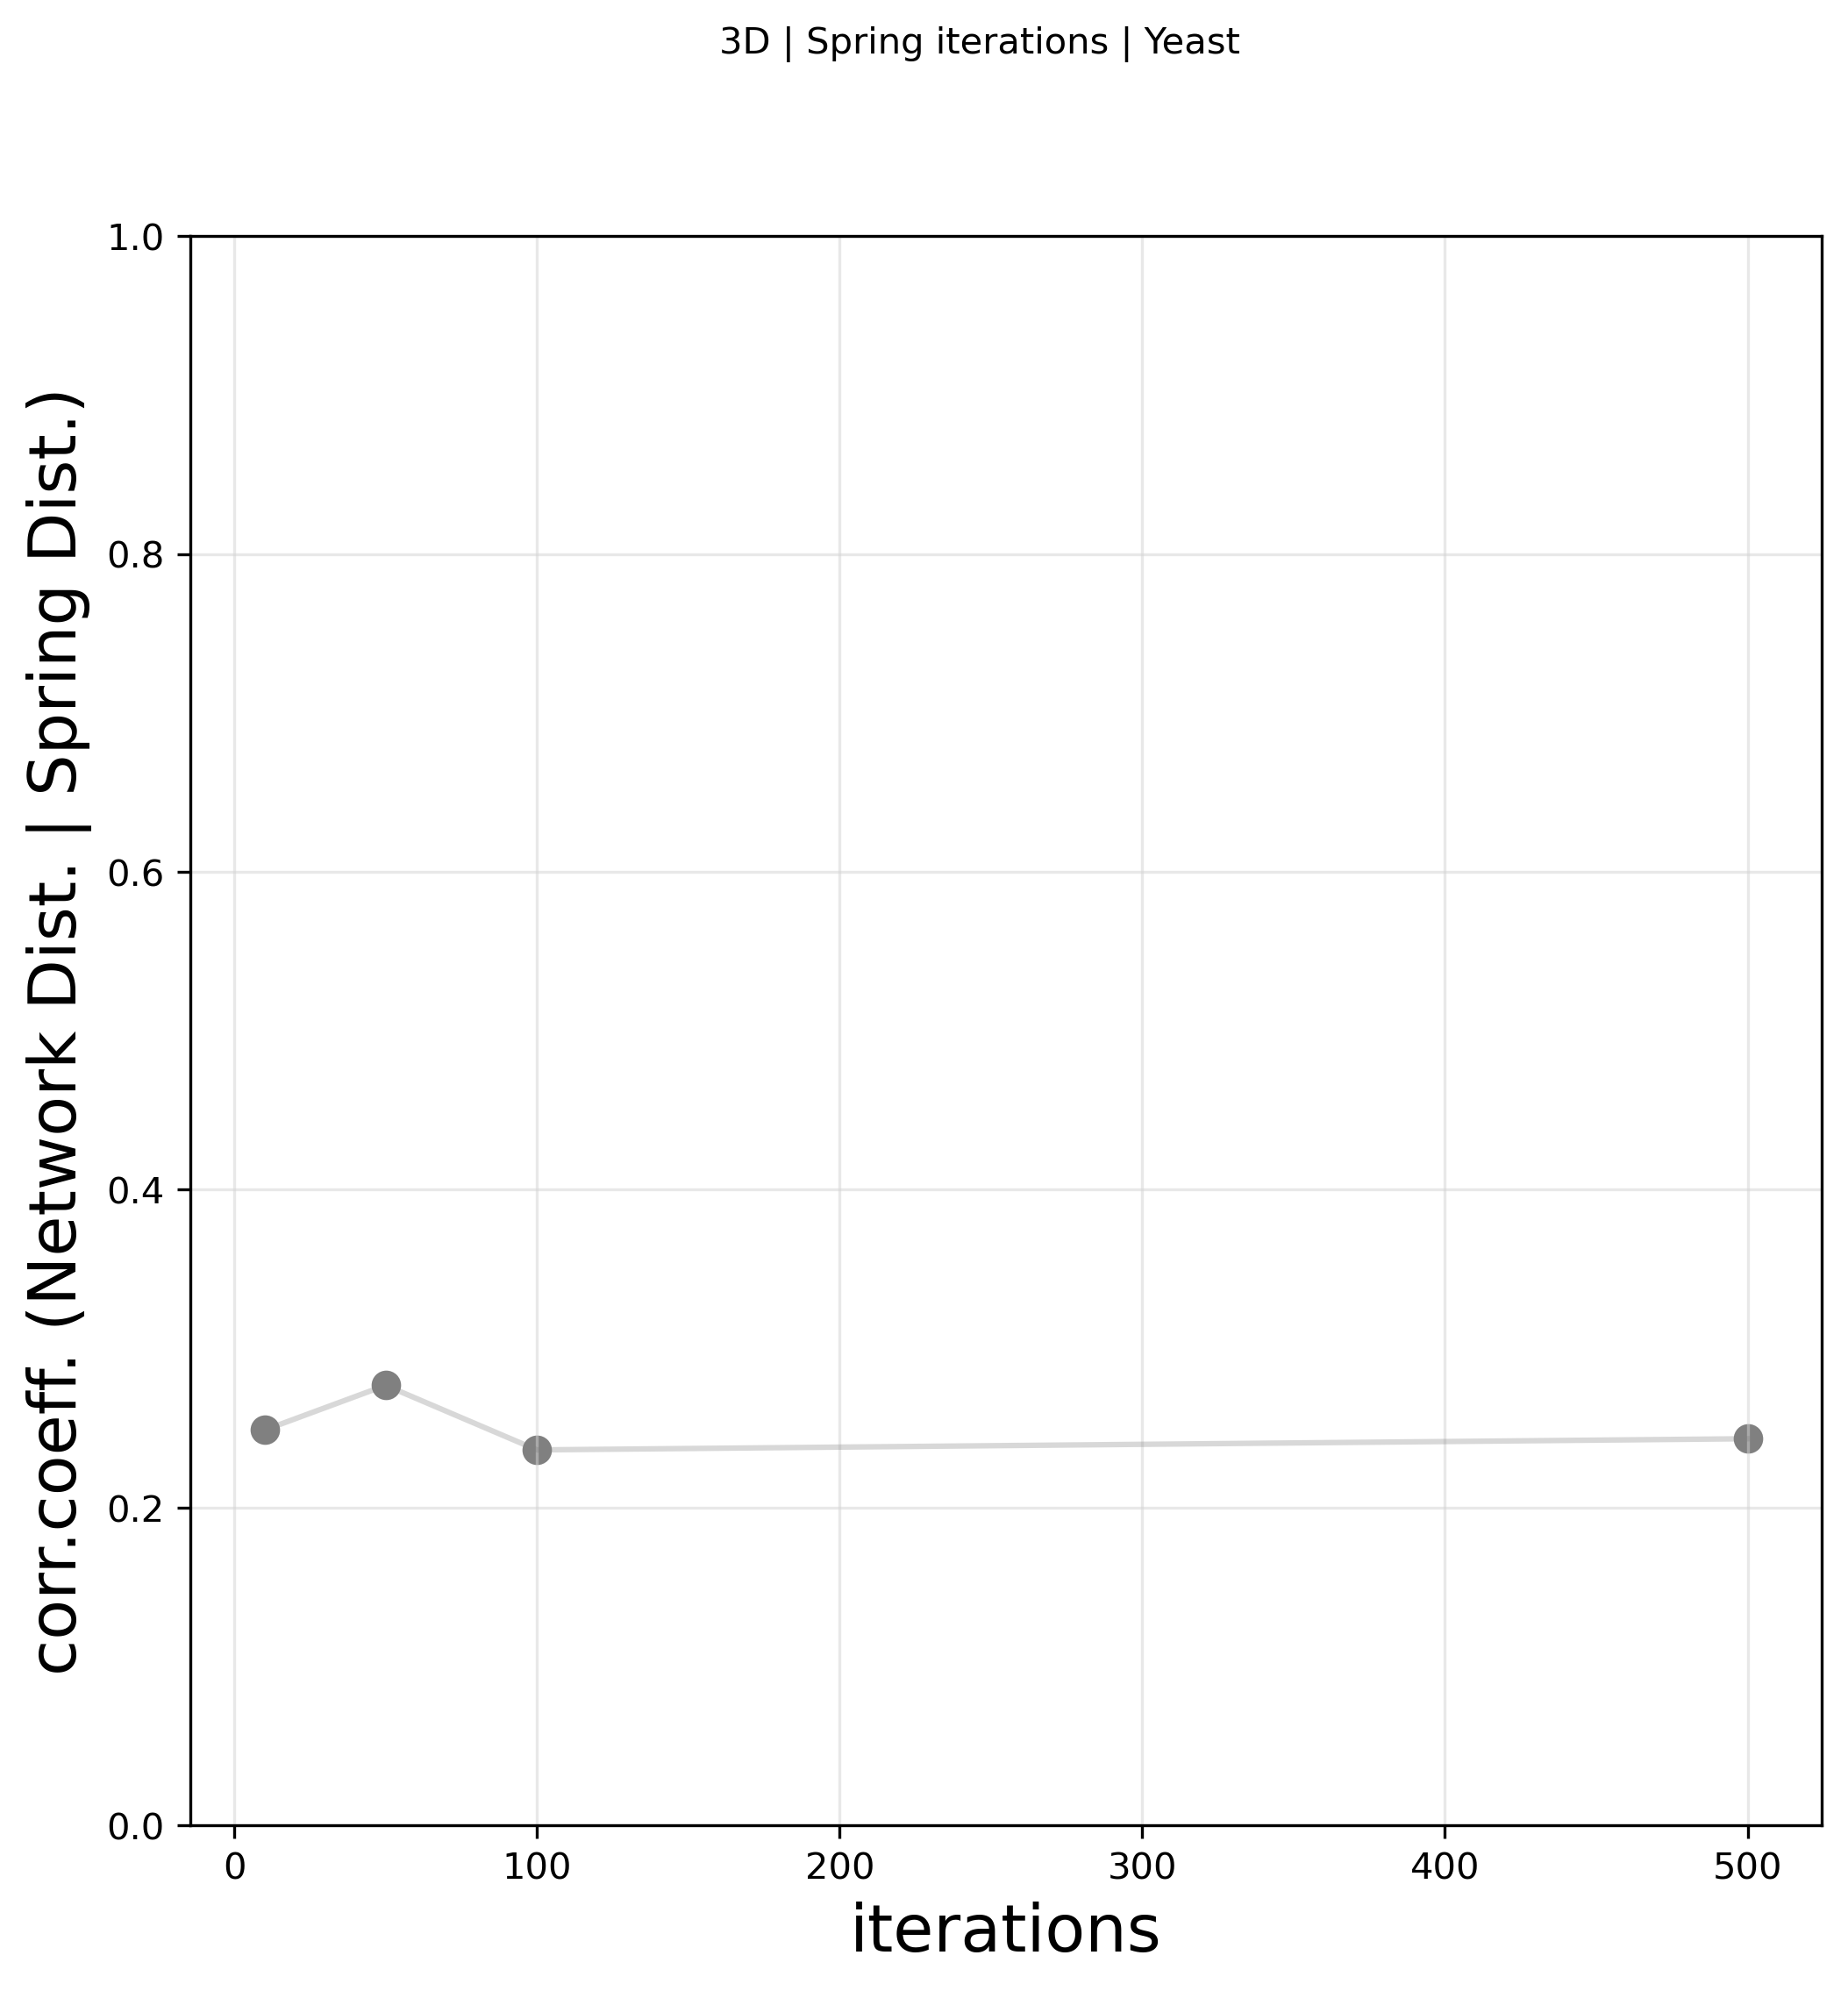

In [354]:
x_corr_spring = list(d_walltimes.keys())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("iterations", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0 ,ymax=1.0)

fig.savefig('output_plots/Correlation3D_'+feature+'_'+organism+'.png')

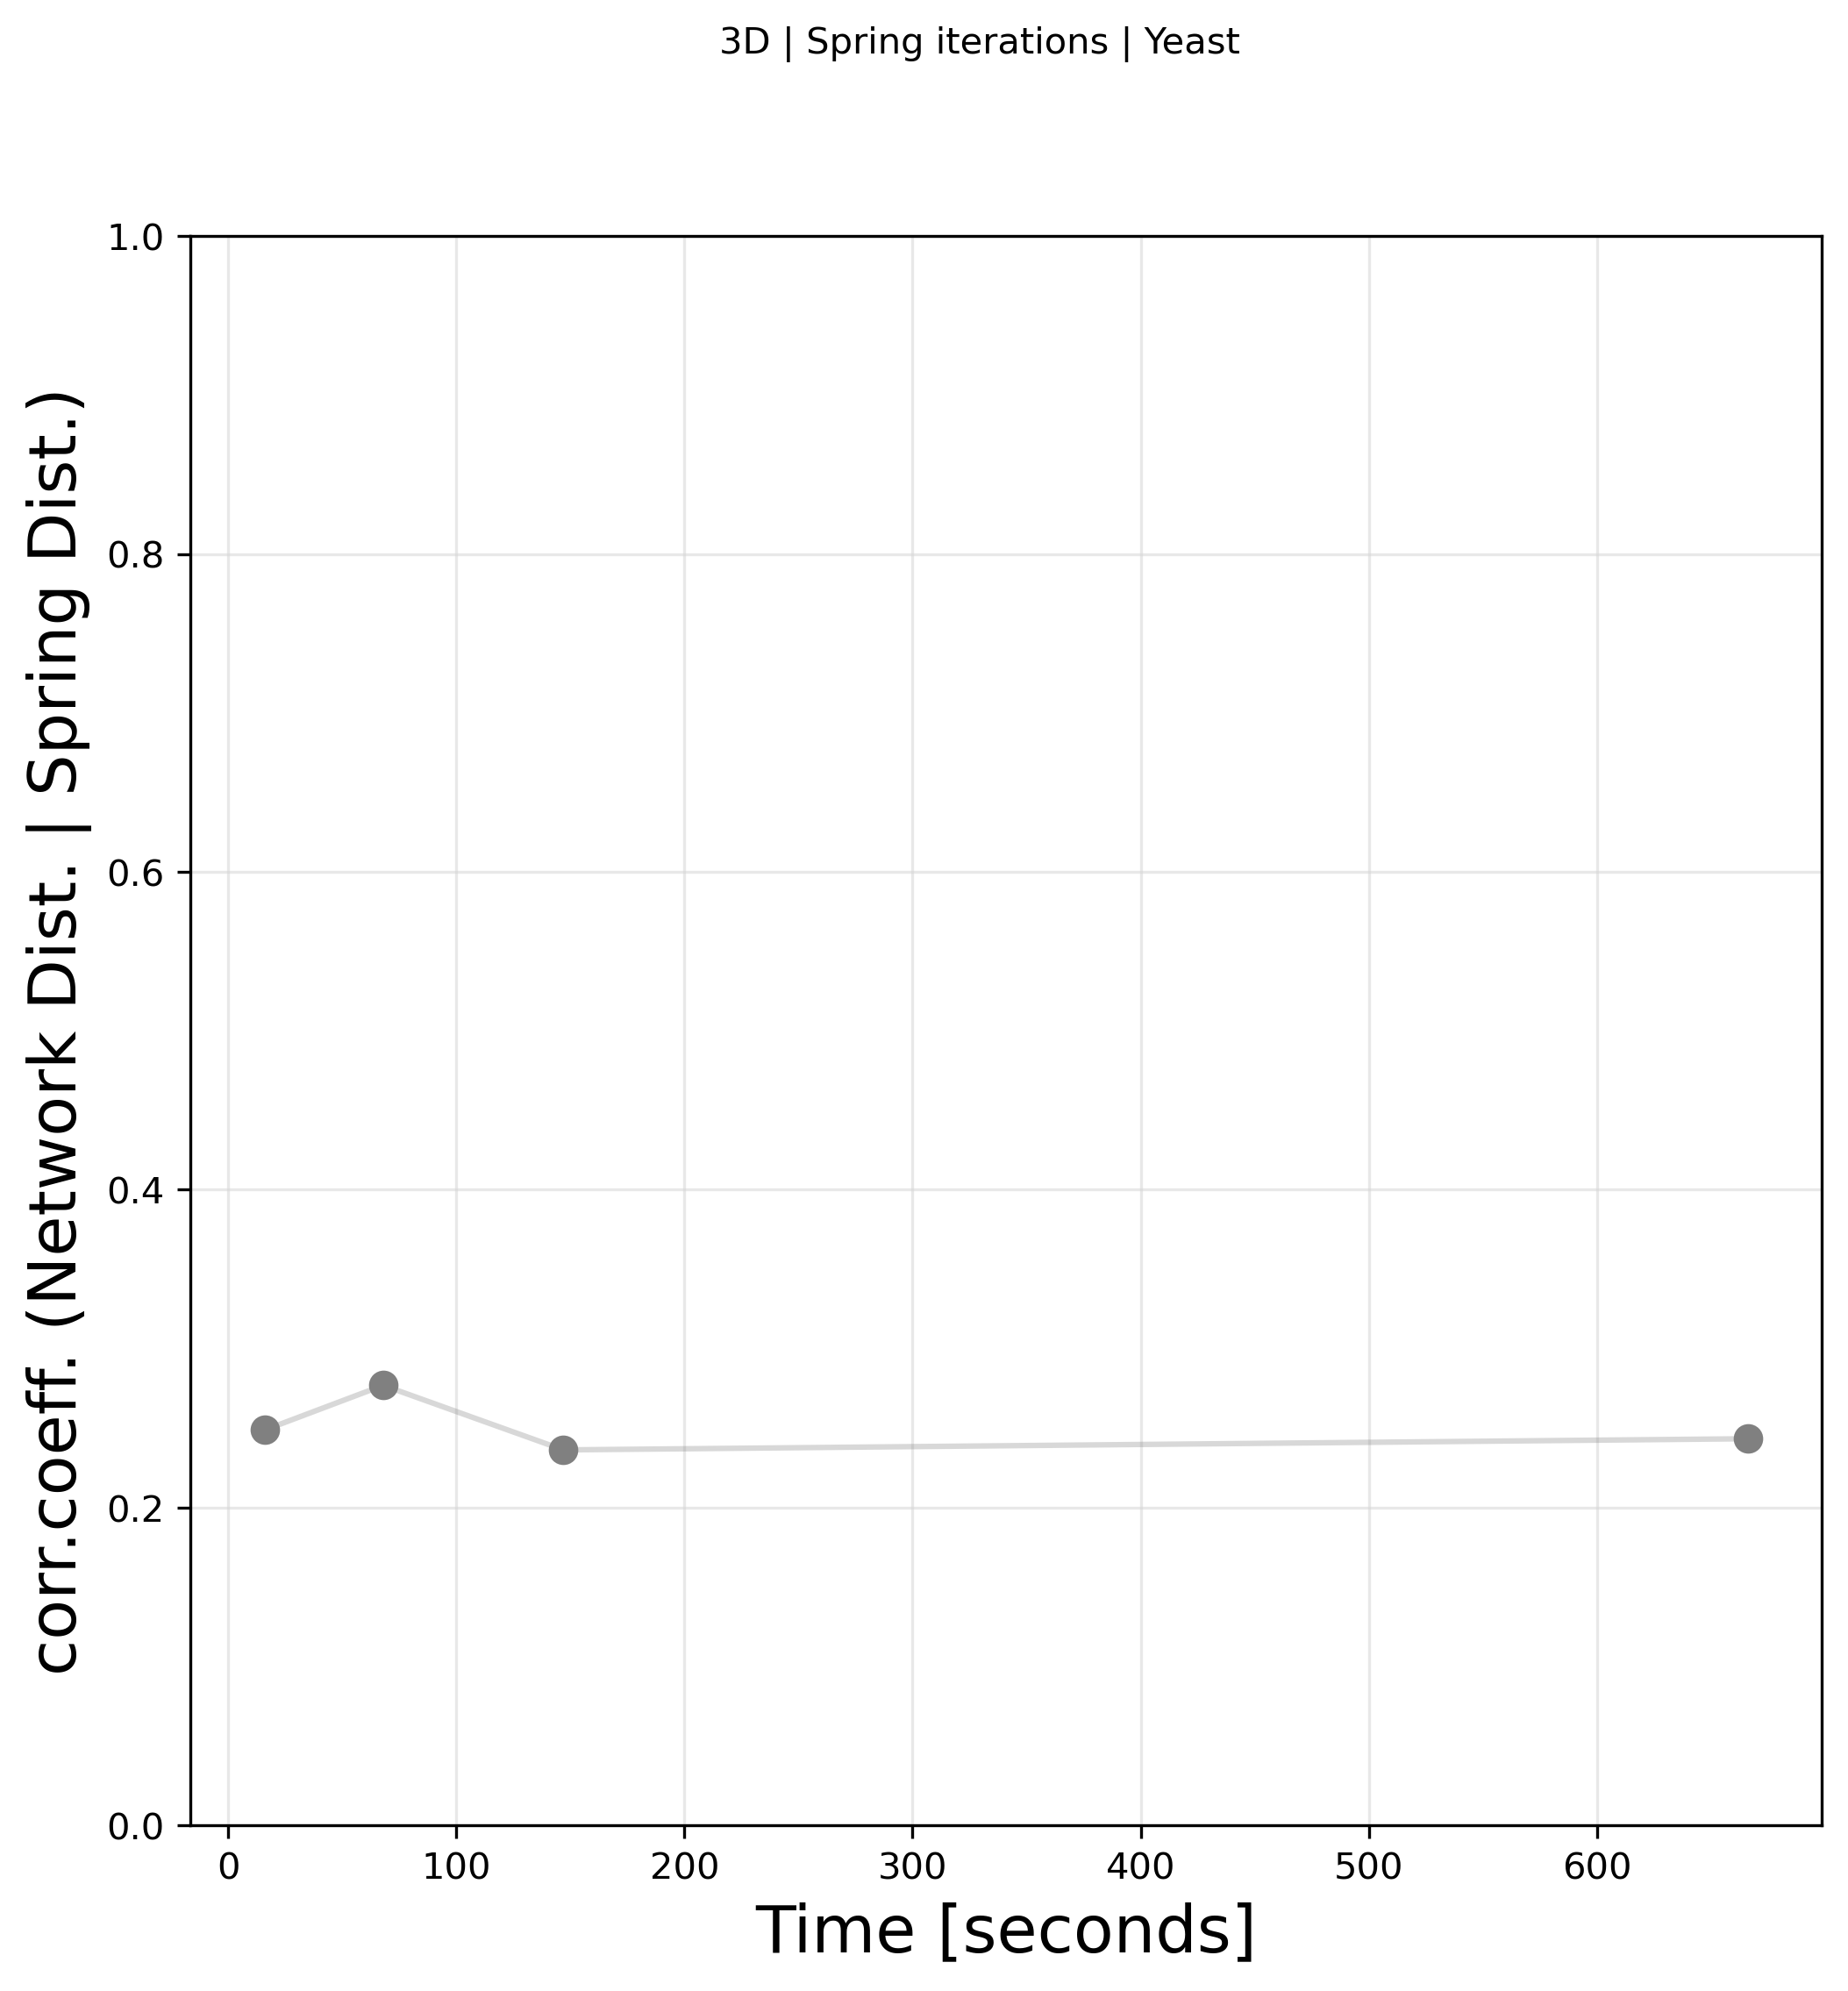

In [355]:
x_corr_spring = list(d_walltimes.values())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("Time [seconds]", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation3D_Time_'+feature+'_'+organism+'.png')

### UMAP - RWR

### Impact of UMAP PARAMETERS to CORRELATION COEFFICIENT (of Network Dist / Layout Dist) 
+ number of neighbors 
+ n_epochs
+ learning rate 
+ spread 
+ min_dist

In [403]:
feature = 'RWRvis'

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 10
spread = 10
min_dist = 0.5

metric ='cosine'
lnr = 1
nep = None

#### ------ NUMBER OF NEIGHBORS ------
+ The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation
+ Larger values result in more global views of the manifold, while smaller values result in more local data being preserved 
+ In general values should be in the range 2 to 100.

In [404]:
# NUMBER OF NEIGHBORS 

n_neighbor_list = [8,10,20,50,100]

d_rwr_neigh = {}
d_r_values_rwr_neigh = {}

for i in n_neighbor_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, i, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP n_neighs:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_neigh[i] = walltime_rwr
    
    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_neigh[i] = r_value_rwr

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_neighs: 8
Execution Time: 00:00:23
min: 0 sec: 23


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_neighs: 10
Execution Time: 00:00:28
min: 0 sec: 28


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_neighs: 20
Execution Time: 00:00:20
min: 0 sec: 20


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_neighs: 50
Execution Time: 00:00:31
min: 0 sec: 31


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_neighs: 100
Execution Time: 00:00:50
min: 0 sec: 50


In [405]:
d_rwr_neigh

{8: 23, 10: 28, 20: 20, 50: 31, 100: 50}

In [406]:
d_r_values_rwr_neigh

{8: 0.029224937192510743,
 10: 0.10069097507132041,
 20: 0.0765122832540239,
 50: 0.047975096581562904,
 100: 0.04695538190552036}

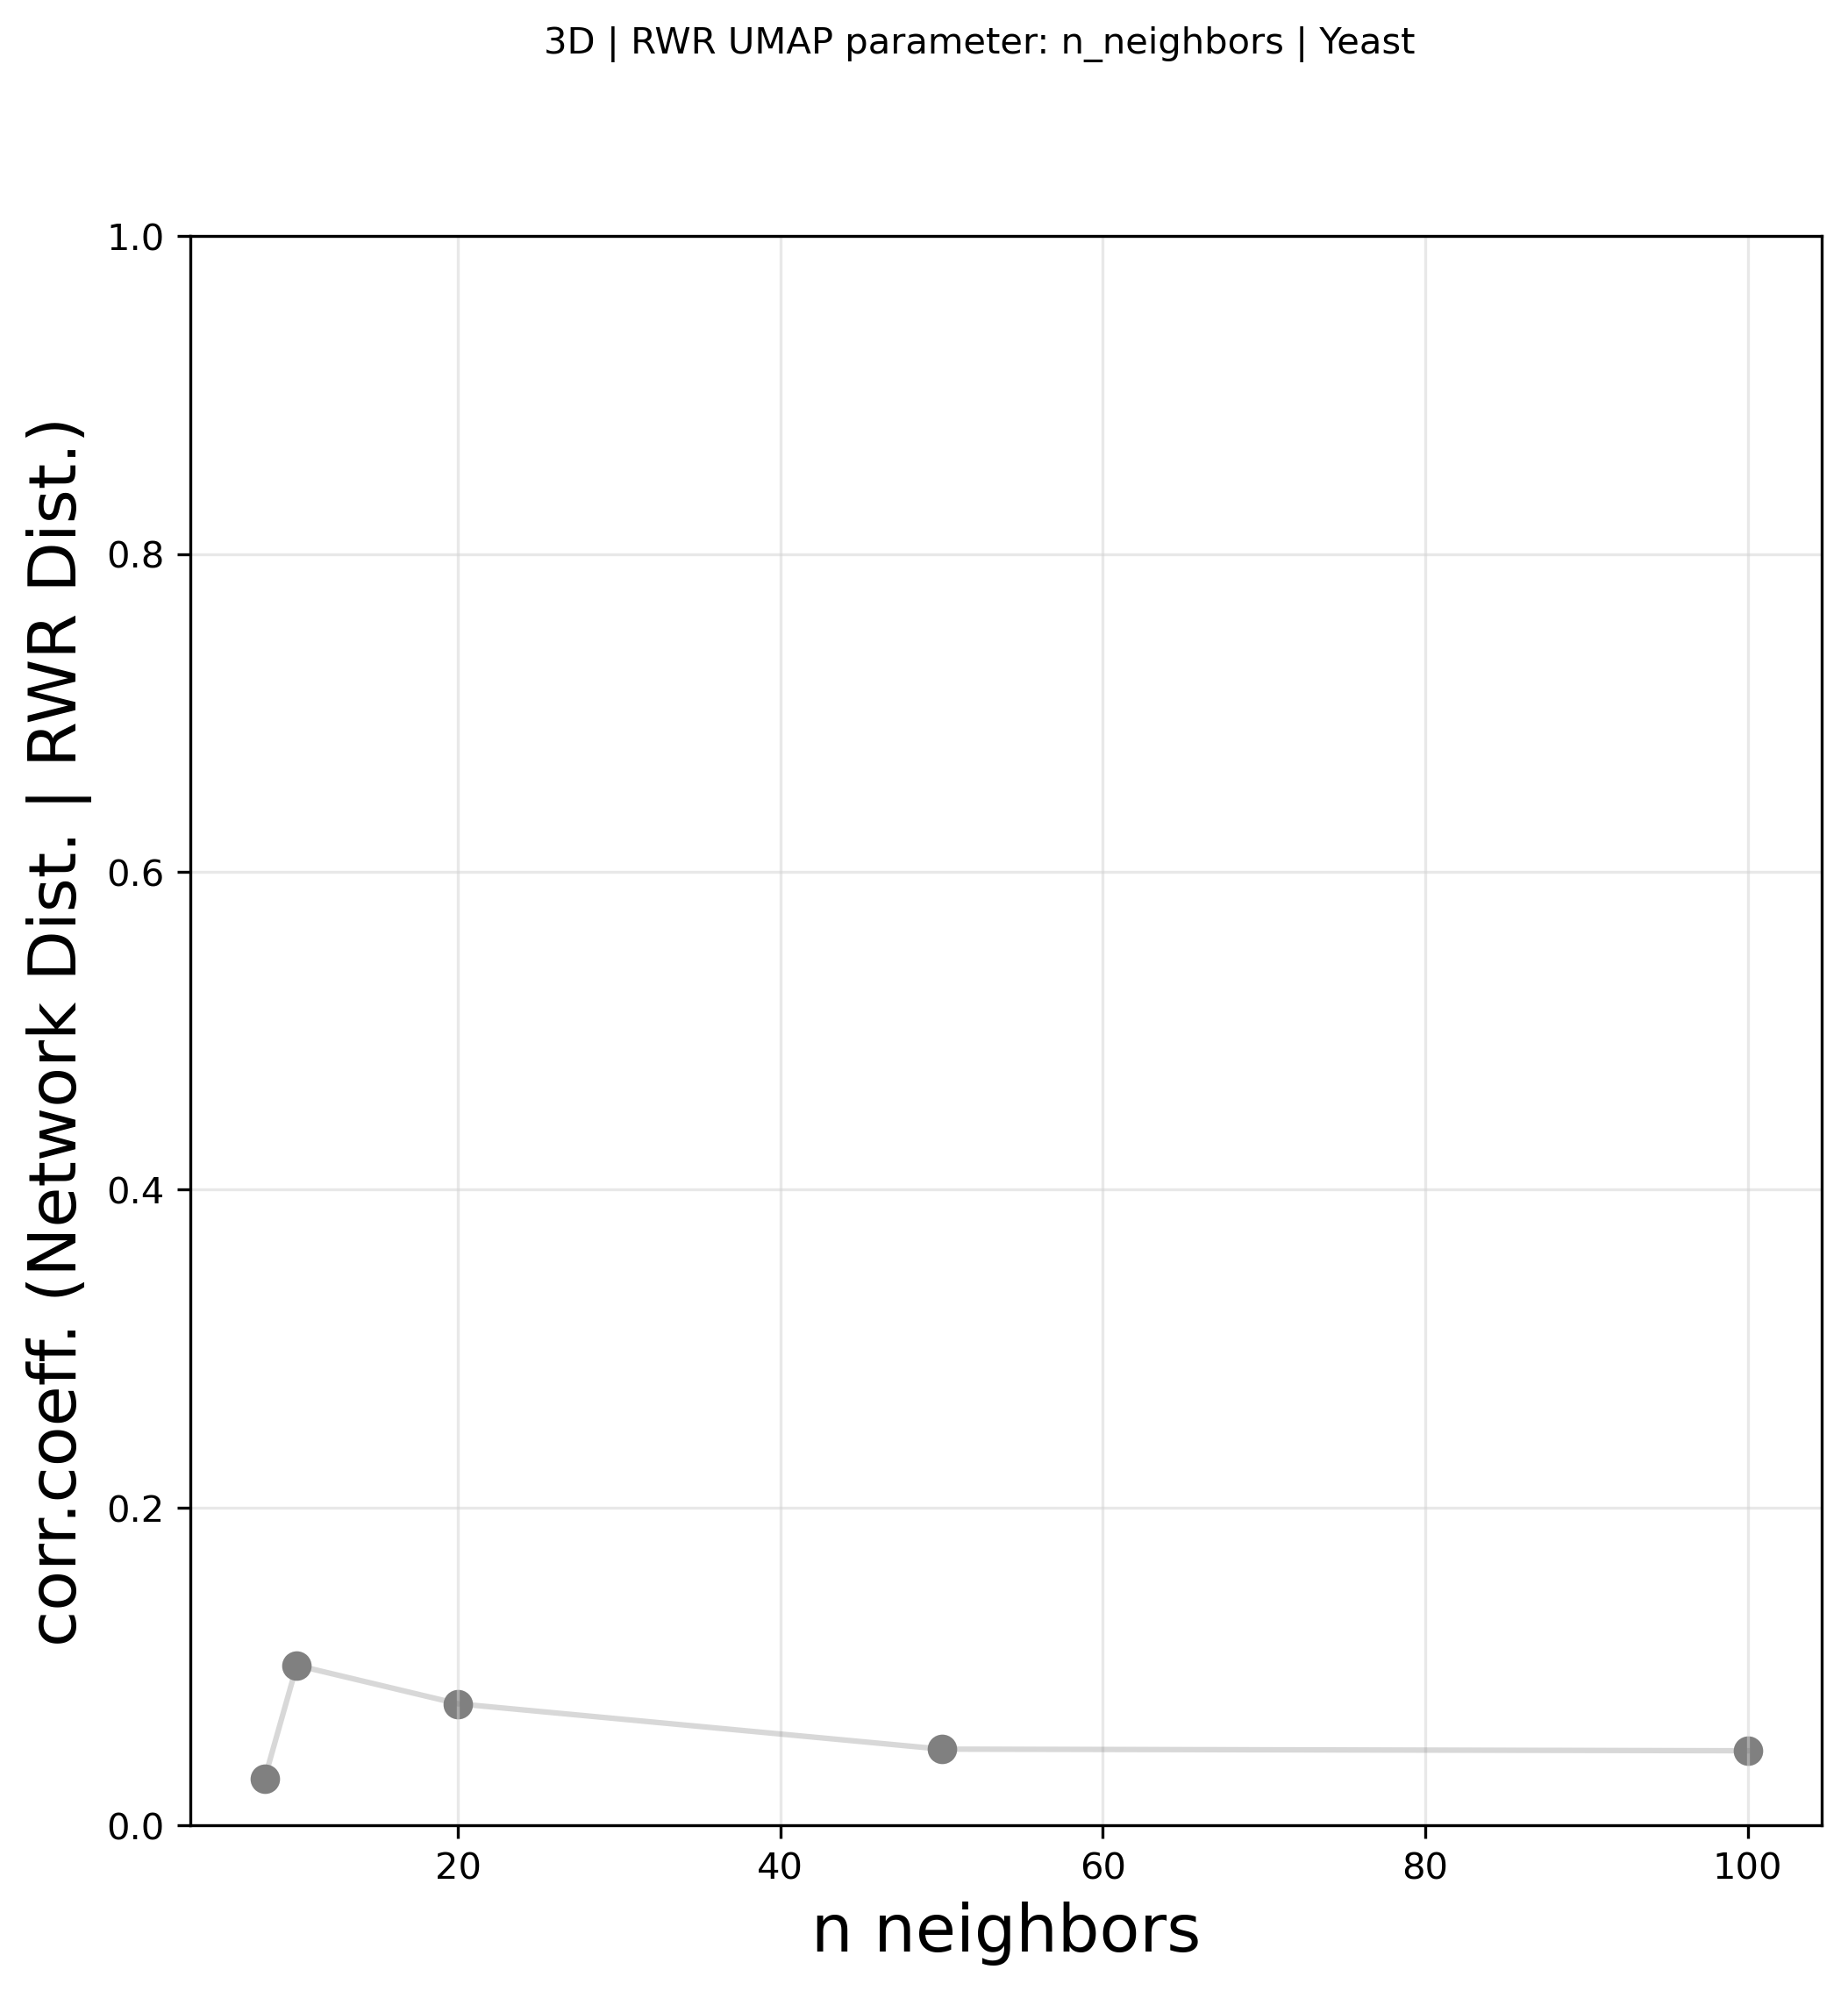

In [407]:
x = list(d_rwr_neigh.keys())
y = list(d_r_values_rwr_neigh.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("n neighbors", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: n_neighbors | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation3D_neighs_'+feature+'_'+organism+'.png')

In [379]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 10
spread = 10
min_dist = 0.5

metric ='cosine'
lnr = 1
nep = None

#### ------ MIN DIST ------
+ The effective minimum distance between embedded points
+ Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points

In [380]:
# MIN DIST 

mindist_list = [0.01,0.0,0.1,0.5,0.9,1]

d_rwr_mdist = {}
d_r_values_rwr_mdist = {}

for i in mindist_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, i, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP min dist:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_mdist[i] = walltime_rwr

    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_mdist[i] = r_value_rwr

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 0.01
Execution Time: 00:00:19
min: 0 sec: 19


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 0.0
Execution Time: 00:00:19
min: 0 sec: 19


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 0.1
Execution Time: 00:00:20
min: 0 sec: 20


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 0.5
Execution Time: 00:00:17
min: 0 sec: 17


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 0.9
Execution Time: 00:00:16
min: 0 sec: 16


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP min dist: 1
Execution Time: 00:00:14
min: 0 sec: 14


In [381]:
d_rwr_mdist

{0.01: 19, 0.0: 19, 0.1: 20, 0.5: 17, 0.9: 16, 1: 14}

In [382]:
d_r_values_rwr_mdist

{0.01: 0.09041844121006697,
 0.0: 0.09302110983942245,
 0.1: 0.09325930181328156,
 0.5: 0.10069097507132041,
 0.9: 0.0975614541679847,
 1: 0.09957105547182218}

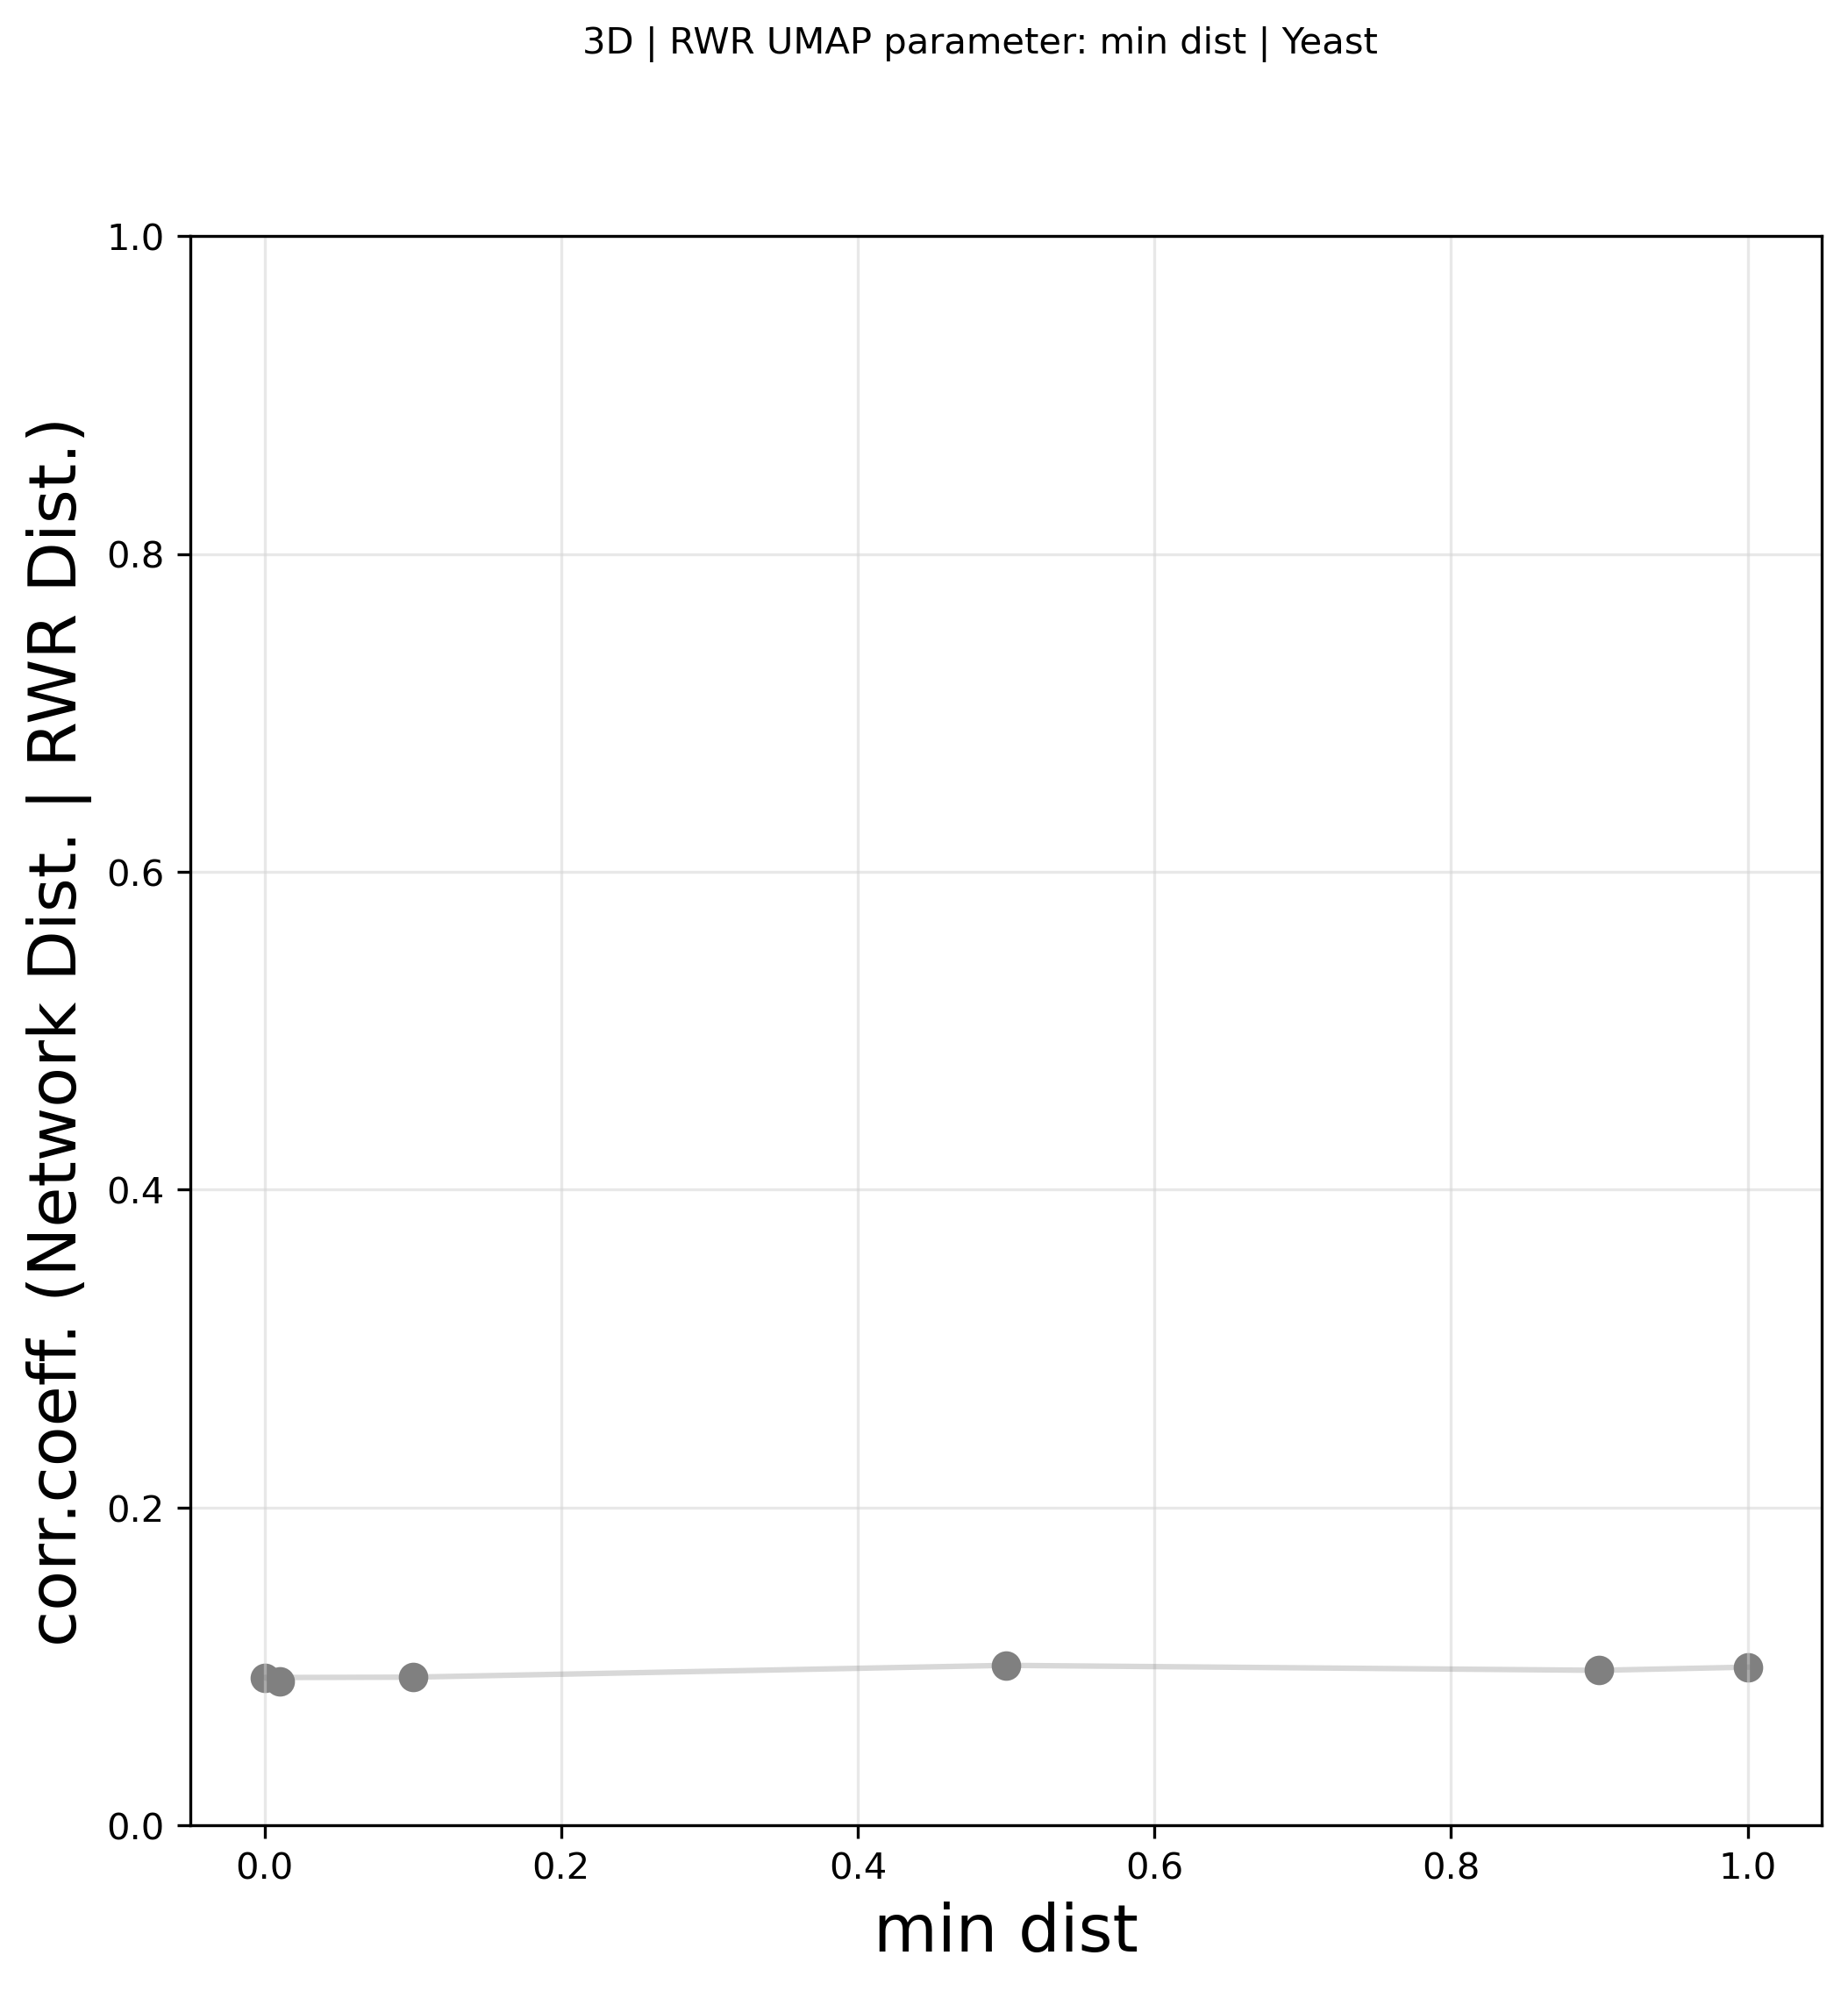

In [383]:
x = list(d_rwr_mdist.keys())
y = list(d_r_values_rwr_mdist.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("min dist", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: min dist | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation3D_mindist_'+feature+'_'+organism+'.png')

In [384]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 10
spread = 10
min_dist = 0.5

metric ='cosine'
lnr = 1
nep = None

#### ------ SPREAD ------
+ The effective scale of embedded points
+ In combination with min_dist this determines how clustered/clumped the embedded points are

In [387]:
# SPREAD

spread_list = [0.9,1,5,10]

d_rwr_spread = {}
d_r_values_rwr_spread  = {}

for i in spread_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, i, min_dist, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP spread:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_spread[i] = walltime_rwr
    
    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_spread[i] = r_value_rwr

UMAP spread: 0.9
Execution Time: 00:00:15
min: 0 sec: 15
UMAP spread: 1
Execution Time: 00:00:17
min: 0 sec: 17


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 5
Execution Time: 00:00:16
min: 0 sec: 16


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 10
Execution Time: 00:00:17
min: 0 sec: 17


In [388]:
d_rwr_spread

{0.9: 15, 1: 17, 5: 16, 10: 17}

In [389]:
d_r_values_rwr_spread

{0.9: 0.09830420215809654,
 1: 0.08529374101204018,
 5: 0.08756541000455309,
 10: 0.10069097507132041}

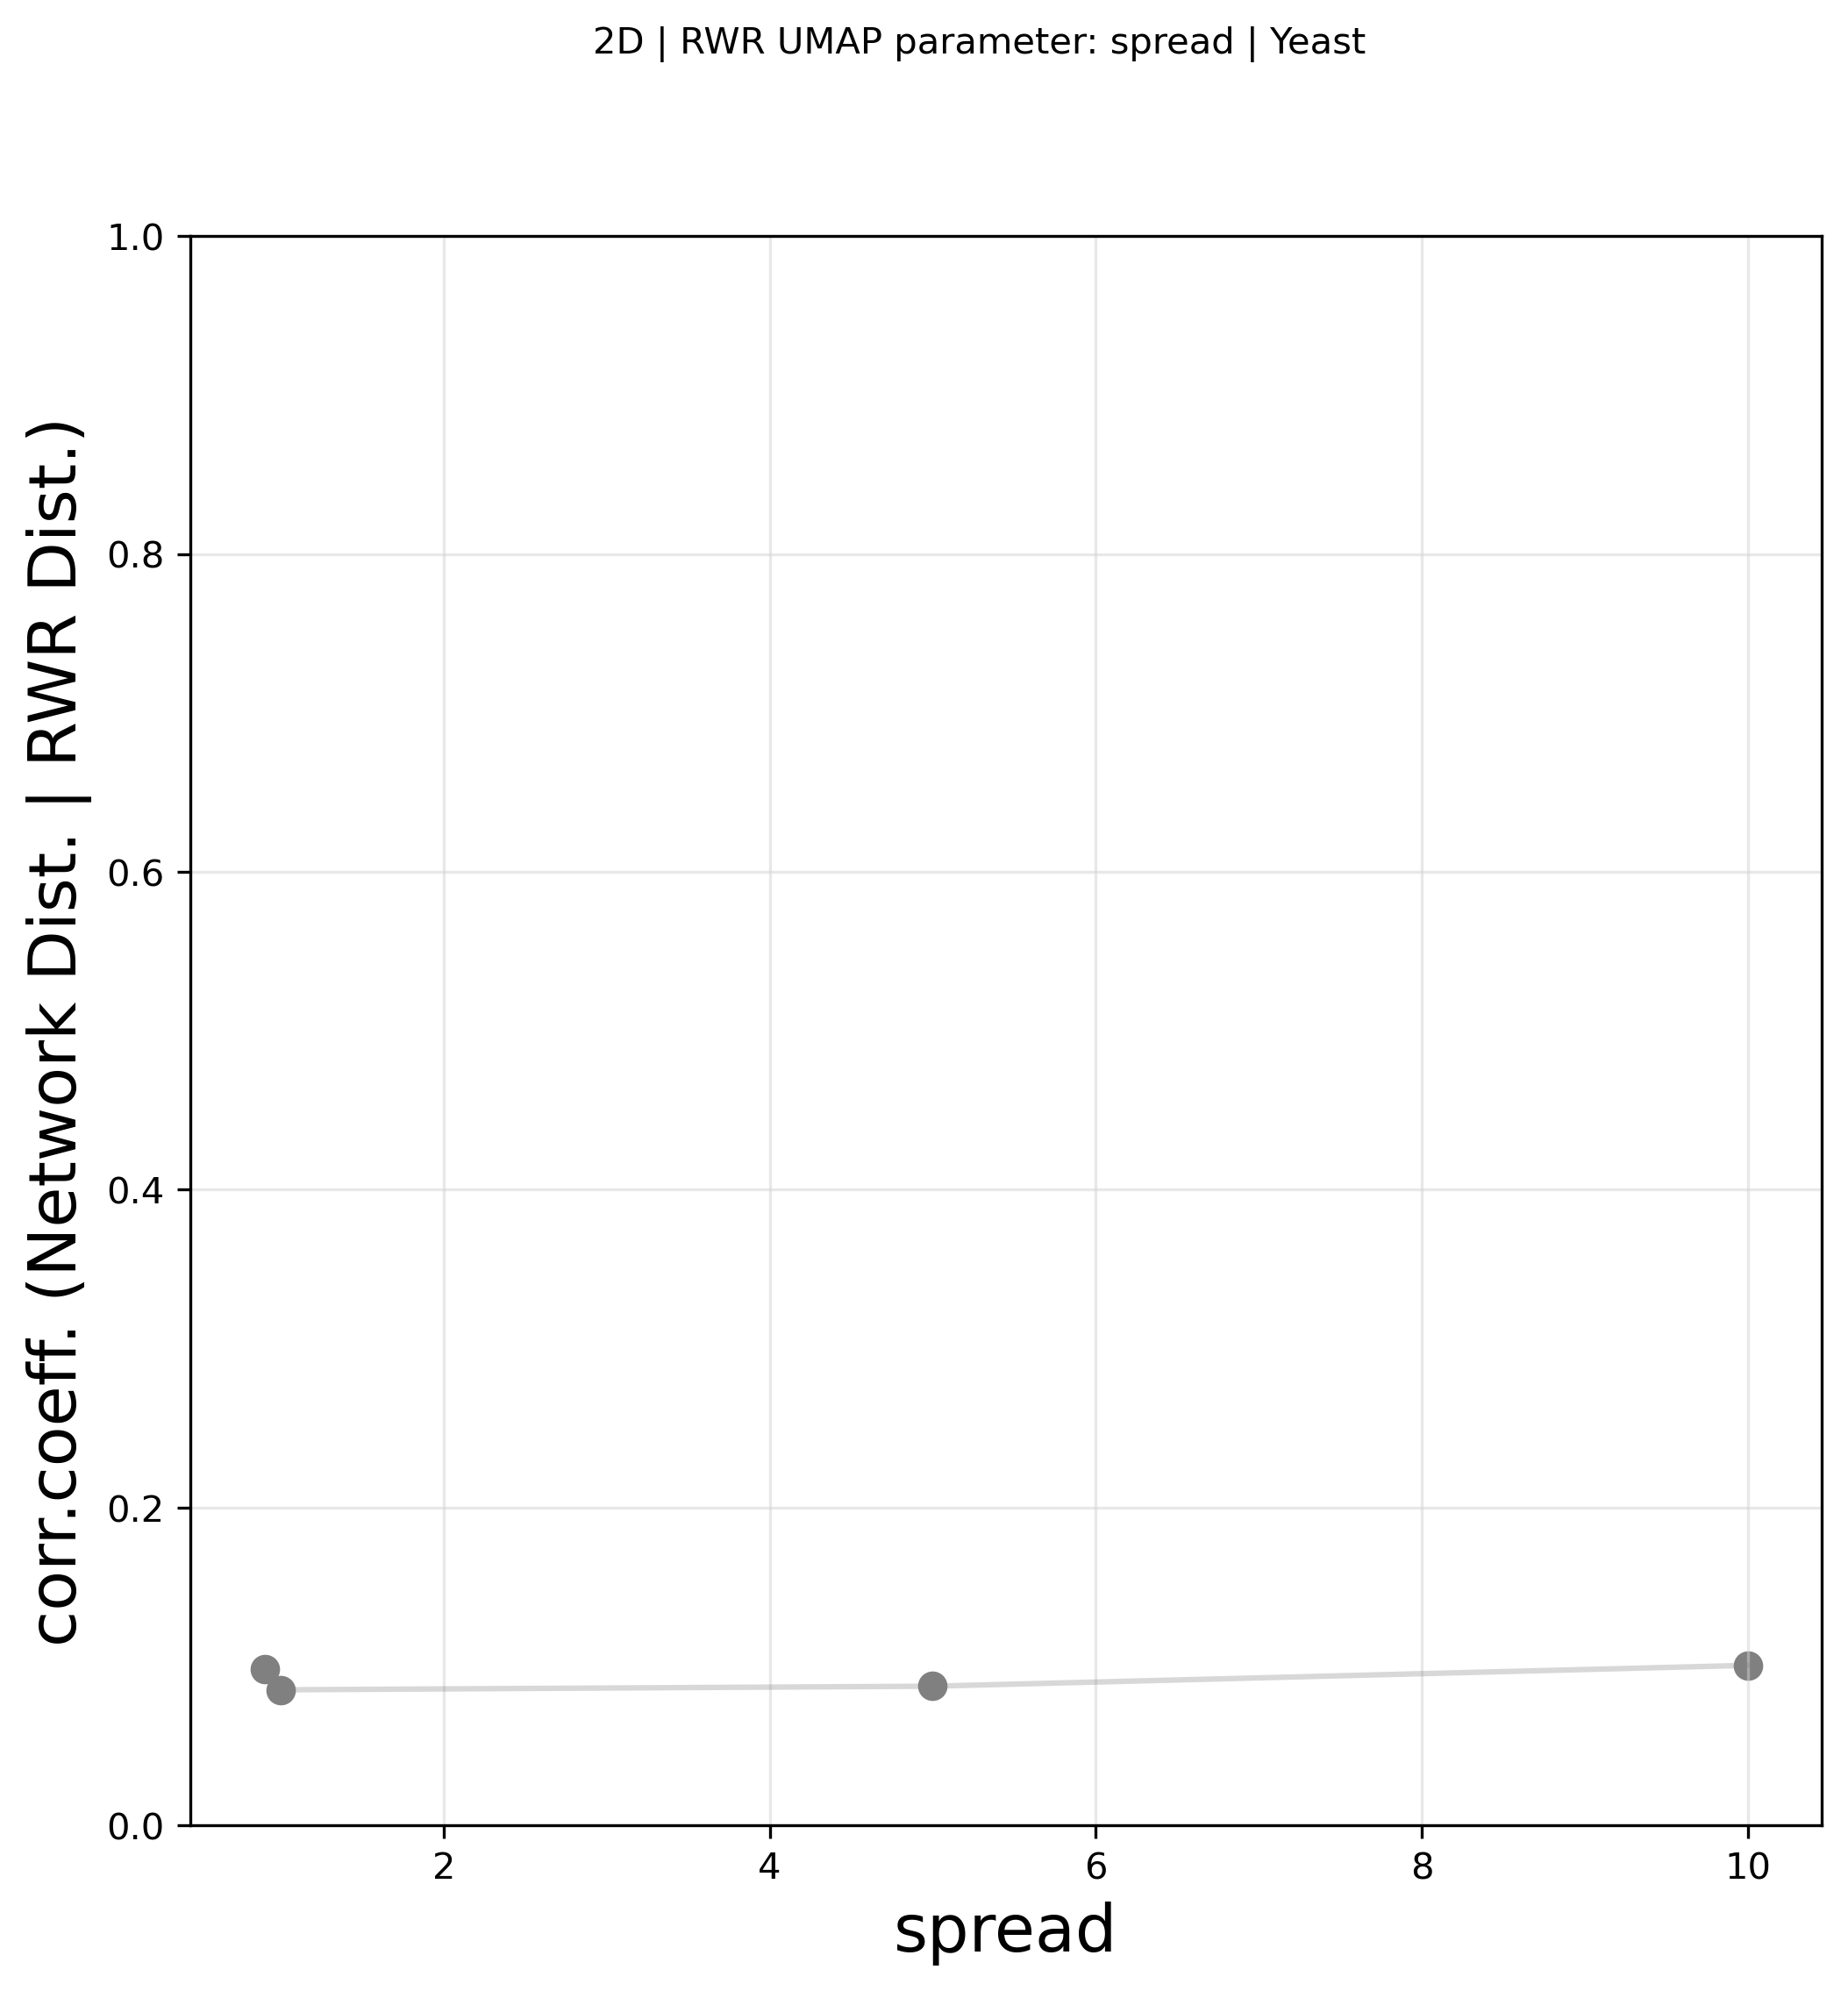

In [390]:
x = list(d_rwr_spread.keys())
y = list(d_r_values_rwr_spread.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("spread", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: spread | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation3D_spread_'+feature+'_'+organism+'.png')

In [840]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 10
spread = 10
min_dist = 0.5

metric = 'cosine'
lnr = 1
nep = None

#### ------ NUMBER OF EPOCHS ------
+ The number of training epochs to be used in optimizing the low dimensional embedding
+ Larger values result in more accurate embeddings 
+ If None is specified a value will be selected based on the size of the input dataset (200 for large datasets, 500 for small)

In [841]:
# NUMBER OF EPOCHS 

nep_list = [None, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

d_rwr_epochs = {}
d_r_values_rwr_nep = {}

for i in nep_list: 
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = i)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP n_epoch:' ,i) 
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_epochs[i] = walltime_rwr
    
    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_nep[i] = r_value_rwr

UMAP n_epoch: None
Execution Time: 00:00:14
min: 0 sec: 14
UMAP n_epoch: 100
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_epoch: 200
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_epoch: 300
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_epoch: 400
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_epoch: 500
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_epoch: 600
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_epoch: 700
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_epoch: 800
Execution Time: 00:00:15
min: 0 sec: 15
UMAP n_epoch: 900
Execution Time: 00:00:15
min: 0 sec: 15
UMAP n_epoch: 1000
Execution Time: 00:00:16
min: 0 sec: 16


In [842]:
d_rwr_epochs

{None: 14,
 100: 13,
 200: 12,
 300: 13,
 400: 12,
 500: 12,
 600: 12,
 700: 13,
 800: 15,
 900: 15,
 1000: 16}

In [843]:
d_r_values_rwr_nep

{None: 0.9066073770832941,
 100: 0.878948188025193,
 200: 0.8937956508695605,
 300: 0.9004449615779604,
 400: 0.9085922368298912,
 500: 0.9066073770832941,
 600: 0.9049115132533673,
 700: 0.9102581326078866,
 800: 0.9081759971663073,
 900: 0.9057516378364027,
 1000: 0.911051425215849}

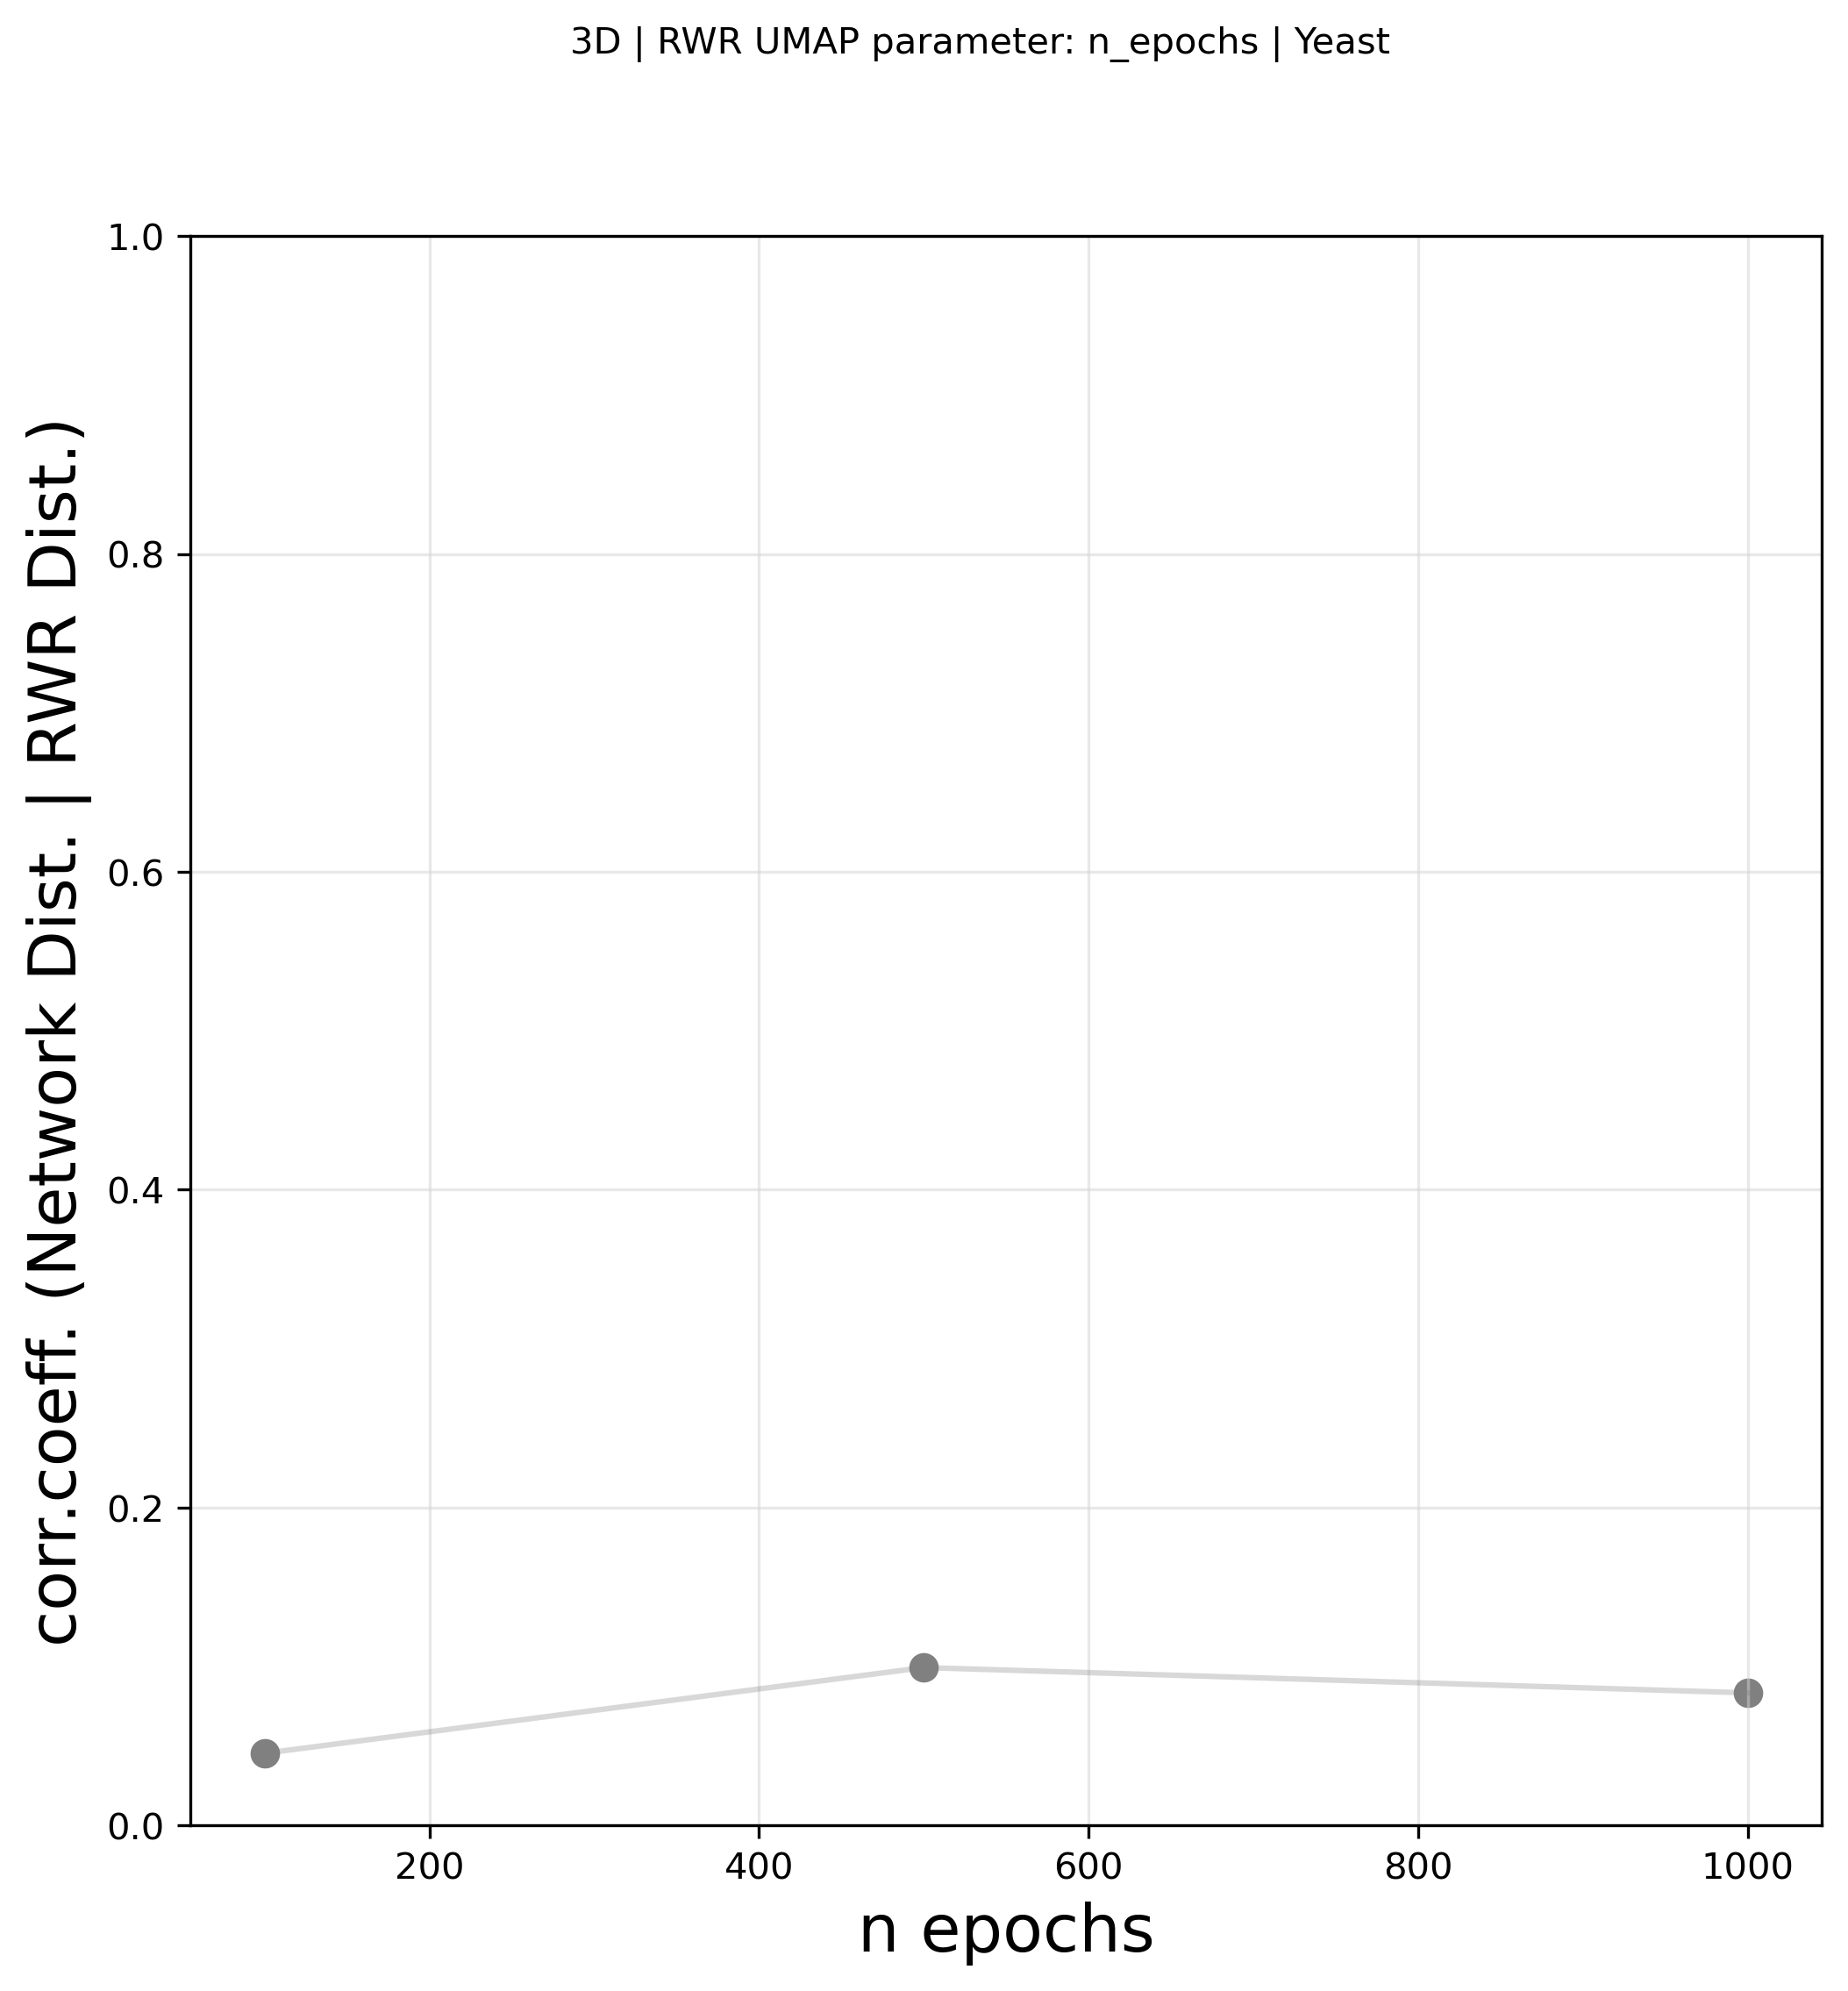

In [408]:
x = list(d_rwr_epochs.keys())
y = list(d_r_values_rwr_nep.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("n epochs", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: n_epochs | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation3D_nepochs_'+feature+'_'+organism+'.png')

In [409]:
#adjust parameters 

#-----------------------------
# INITIAL UMAP PARAMETERS:
#-----------------------------
n_neighbors = 10
spread = 10
min_dist = 0.5
metric = 'cosine'
lnr = 1
nep = None

#### ------ LEARNING RATE ------
+ The initial learning rate for the embedding optimization

In [410]:
# LEARNING RATE 

lnr_list = [0.001,0.01,0.1,1,10,100,200,300,400,500,600,700,800,900,1000]

d_rwr_lnr = {}
d_r_values_rwr_lnr = {}

for i in lnr_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = i, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP learning rate:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_lnr[i] = walltime_rwr
    
    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_lnr[i] = r_value_rwr

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 0.001
Execution Time: 00:00:14
min: 0 sec: 14


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 0.01
Execution Time: 00:00:17
min: 0 sec: 17


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 0.1
Execution Time: 00:00:13
min: 0 sec: 13


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 1
Execution Time: 00:00:16
min: 0 sec: 16


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 10
Execution Time: 00:00:19
min: 0 sec: 19


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 100
Execution Time: 00:00:30
min: 0 sec: 30


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



KeyboardInterrupt: 

In [ ]:
d_rwr_lnr

In [ ]:
d_r_values_rwr_lnr

In [ ]:
x = list(d_rwr_lnr.keys())
y = list(d_r_values_rwr_lnr.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("learning rate", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: learning rate | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/Correlation3D_learnrate_'+feature+'_'+organism+'.png')